In [17]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
from scipy import stats
import utils.plot
import models.train_metaClf

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

resolution='5'
savedir_baseline='/data/xzhang/neuro/results/jointClustering/baseline/res'+resolution
with open(os.path.join(savedir_baseline,'pca_dapi_600'), 'rb') as output:
    pca_dapi=pickle.load(output)
with open(os.path.join(savedir_baseline,'pca_gfap_600'), 'rb') as output:
    pca_gfap=pickle.load(output)
with open(os.path.join(savedir_baseline,'pca_map2_600'), 'rb') as output:
    pca_map2=pickle.load(output)
with open(os.path.join(savedir_baseline,'pca_lmnb_600'), 'rb') as output:
    pca_lmnb=pickle.load(output)
with open(os.path.join(savedir_baseline,'modAll'), 'rb') as output:
    modAll=pickle.load(output)
with open(os.path.join(savedir_baseline,'silAll'), 'rb') as output:
    silAll=pickle.load(output)
with open(os.path.join(savedir_baseline,'moddapi'), 'rb') as output:
    moddapi=pickle.load(output)
with open(os.path.join(savedir_baseline,'sildapi'), 'rb') as output:
    sildapi=pickle.load(output)
with open(os.path.join(savedir_baseline,'modgfap'), 'rb') as output:
    modgfap=pickle.load(output)
with open(os.path.join(savedir_baseline,'silgfap'), 'rb') as output:
    silgfap=pickle.load(output)
with open(os.path.join(savedir_baseline,'modmap2'), 'rb') as output:
    modmap2=pickle.load(output)
with open(os.path.join(savedir_baseline,'silmap2'), 'rb') as output:
    silmap2=pickle.load(output)
with open(os.path.join(savedir_baseline,'modlmnb'), 'rb') as output:
    modlmnb=pickle.load(output)
with open(os.path.join(savedir_baseline,'sillmnb'), 'rb') as output:
    sillmnb=pickle.load(output)
with open(os.path.join(savedir_baseline,'leidenRes3_10samples'), 'rb') as output:
    leidenResAll=pickle.load(output)
    
savedir_processed='/data/xzhang/neuro/processed'
resDir='/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall'
saveDir=os.path.join(savedir_baseline,'cnnvaeexp0_segNucall')
if not os.path.exists(saveDir):
    os.mkdir(saveDir)


with open(os.path.join(resDir,'leiden_res'+resolution), 'rb') as output:
    finalPartition=pickle.load(output)
    
jointPartition=np.copy(finalPartition)
modFrac=0.3
modFrac_dapi=(moddapi/modAll>modFrac).astype(int)
modFrac_map2=(modmap2/modAll>modFrac).astype(int)
modFrac_gfap=(modgfap/modAll>modFrac).astype(int)
modFrac_lmnb=(modlmnb/modAll>modFrac).astype(int)
modFrac_sum=modFrac_dapi+modFrac_gfap+modFrac_lmnb+modFrac_map2

silAll_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silAll_mean[c]=np.mean(silAll[jointPartition==c])
    
sildapi_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    sildapi_mean[c]=np.mean(sildapi[jointPartition==c])
    
silgfap_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silgfap_mean[c]=np.mean(silgfap[jointPartition==c])

silmap2_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silmap2_mean[c]=np.mean(silmap2[jointPartition==c])
sillmnb_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    sillmnb_mean[c]=np.mean(sillmnb[jointPartition==c])
silAll_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silAll_pos[c]=np.sum(silAll[jointPartition==c]>0)/np.sum(jointPartition==c)
sildapi_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    sildapi_pos[c]=np.sum(sildapi[jointPartition==c]>0)/np.sum(jointPartition==c)
silmap2_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silmap2_pos[c]=np.sum(silmap2[jointPartition==c]>0)/np.sum(jointPartition==c)
silgfap_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silgfap_pos[c]=np.sum(silgfap[jointPartition==c]>0)/np.sum(jointPartition==c)
sillmnb_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    sillmnb_pos[c]=np.sum(sillmnb[jointPartition==c]>0)/np.sum(jointPartition==c)

silmean_frac=0.3
silmean_frac_neg=2
def comparesilmean(sildapi_mean,silAll_mean,silmean_frac,silmean_frac_neg):
    silmean_frac_dapi=np.zeros(silAll_mean.size)
    sildapi_mean_posIdx=np.arange(silAll_mean.size)[sildapi_mean>0]
    sildapi_mean_negIdx=np.arange(silAll_mean.size)[sildapi_mean<0]
#     print(sildapi_mean_negIdx[sildapi_mean[sildapi_mean<0]>(silAll_mean[sildapi_mean<0]*silmean_frac_neg)])
    silmean_frac_dapi[sildapi_mean_posIdx[sildapi_mean[sildapi_mean>0]>(silAll_mean[sildapi_mean>0]*silmean_frac)]]=1
    silmean_frac_dapi[sildapi_mean_negIdx[sildapi_mean[sildapi_mean<0]>(silAll_mean[sildapi_mean<0]*silmean_frac_neg)]]=1

    return silmean_frac_dapi

silmean_frac_dapi=comparesilmean(sildapi_mean,silAll_mean,silmean_frac,silmean_frac_neg)
silmean_frac_gfap=comparesilmean(silgfap_mean,silAll_mean,silmean_frac,silmean_frac_neg)
silmean_frac_map2=comparesilmean(silmap2_mean,silAll_mean,silmean_frac,silmean_frac_neg)
silmean_frac_lmnb=comparesilmean(sillmnb_mean,silAll_mean,silmean_frac,silmean_frac_neg)

silmean_frac_sum=silmean_frac_dapi+silmean_frac_gfap+silmean_frac_map2+silmean_frac_lmnb

silpos_frac=0.3
silpos_dapi=(sildapi_pos/silAll_pos>silpos_frac).astype(int)
silpos_gfap=(silgfap_pos/silAll_pos>silpos_frac).astype(int)
silpos_map2=(silmap2_pos/silAll_pos>silpos_frac).astype(int)
silpos_lmnb=(sillmnb_pos/silAll_pos>silpos_frac).astype(int)

silPos_sum=silpos_dapi+silpos_gfap+silpos_map2+silpos_lmnb


clusterIdx_pass=np.arange(np.unique(finalPartition).size)[(modFrac_sum>1)+(silmean_frac_sum>1)+(silPos_sum>1)]

nsamples=10
leidenJoint_overlap=np.zeros((np.unique(jointPartition).size,nsamples))
for cj in np.unique(jointPartition):
    for s in range(nsamples):
        _,counts=np.unique(leidenResAll[jointPartition==cj,s],return_counts=True)
        leidenJoint_overlap[cj,s]=np.max(counts)/np.sum(jointPartition==cj)

overlap_mean=np.mean(leidenJoint_overlap,axis=1)
overlap_std=np.std(leidenJoint_overlap,axis=1)

overlap_mean=np.mean(leidenJoint_overlap,axis=1)
overlap_std=np.std(leidenJoint_overlap,axis=1)

randomAll=np.zeros((leidenResAll.shape[0],nsamples)).astype(int)

for s in range(nsamples):
    randomS=np.copy(jointPartition)
    np.random.seed(s)
    np.random.shuffle(randomS)

    randomAll[:,s]=randomS
leidenJoint_overlap_random=np.zeros((np.unique(jointPartition).size,nsamples))
for cj in np.unique(jointPartition):
    for s in range(nsamples):
        _,counts=np.unique(randomAll[jointPartition==cj,s],return_counts=True)
        leidenJoint_overlap_random[cj,s]=np.max(counts)/np.sum(jointPartition==cj)

overlap_mean_random=np.mean(leidenJoint_overlap_random,axis=1)
overlap_std_random=np.std(leidenJoint_overlap_random,axis=1)

clusterIdx_robust=np.arange(np.unique(finalPartition).size)[(overlap_mean-overlap_std)>(overlap_mean_random+overlap_std_random)]
finalPartition_keep=np.intersect1d(clusterIdx_robust,clusterIdx_pass)


    
with open(os.path.join(savedir_processed,'meta_processed'), 'rb') as output:
    meta=pickle.load(output)

# annoUsed=np.array(['AAO', 'AAD', 'Duration', 'Gender','Clinical Diag','Brain Weight', 'Mutations',
#                    'APOE', 'Braak Tau', 'Thal Phase', 'CERAD', 'CAA', 'SVD','alpha-syn', 'TDP43'])
annoUsed=np.array(['Path Diag','Clinical Diag','Brain Weight', 'Mutations',
                   'APOE', 'Braak Tau', 'Thal Phase', 'CERAD', 'CAA', 'SVD','alpha-syn', 'TDP43',
                   'AAO', 'AAD', 'Duration', 'Gender'])
annoUsed_numeric=np.array(['AAO', 'AAD', 'Duration','Brain Weight','Braak Tau', 'Thal Phase', 'CERAD', 'CAA', 'SVD'])

meta=meta[annoUsed]
stains=np.array(['DAPI','GFAP','MAP2','LMNB'])

    
finalPartition_keepIdx=np.repeat(False, finalPartition.size)
for c in finalPartition_keep:
    finalPartition_keepIdx[finalPartition==c]=True
finalPartition_keep_input=np.copy(finalPartition)
finalPartition_keep_input[np.logical_not(finalPartition_keepIdx)]=-1



In [3]:
with open(os.path.join(savedir_processed,'allPatientID'), 'rb') as output:
    allPatientIDs=pickle.load(output)
meta=meta.loc[np.unique(allPatientIDs)]

with open(os.path.join(savedir_processed,'allImgNames'), 'rb') as output:
    allImgNames=pickle.load(output)
print(np.unique(allImgNames).size)
print(np.unique(allPatientIDs).size)



64
50


In [4]:
#get cluster composition
seeds=[4,8,9,10,11,12]
clusterUnique=np.unique(finalPartition_keep_input)
    
annoPlot_cat=np.array(['Path Diag','APOE','TDP43','alpha-syn'])
annoCatOrder={'Path Diag':np.array(['Control','AD','FTLD-TDPC','PSP','IPD']),
              'Clinical Diag':np.array(['Control','AD','FTD-AD','FTLD','FTD-MND' 'FTD-SD'  'FTLD-PNFA','FTLD-PPA','bvFTD','atypical FTD','NFA','PSP','PD','IPD', 'CBD','Non specific demetia']),
              'APOE':['33','34','24']}
annoPlot_baseline={'Path Diag':'Control',
                   'Clinical Diag':'Control',
                   'APOE':'33',
                   'TDP43':'0.0',
                   'alpha-syn':'0.0'}

#plot IG
plotIGsavepath='/data/xzhang/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/metadataClf/igPlotsControl'
if not os.path.exists(plotIGsavepath):
    os.mkdir(plotIGsavepath)
plotIGsavepath_thresh=os.path.join(plotIGsavepath,'thresh')
if not os.path.exists(plotIGsavepath_thresh):
    os.mkdir(plotIGsavepath_thresh)

igPlotAll_mean=None
igPlotAll_std=None
stdThresh=1
sampleNames_plot=[]
for anno in annoPlot_cat:
    print(anno)
    
    avgIG=None
    predictedLabels=None
    trueLabels=None
    
    #construct labels
    
    meta['keep']=True
    if anno not in annoUsed_numeric:
        pathDiag_unique_keep,pathDiag_inverse_keep,pathDiag_counts_keep=np.unique(meta[anno].astype(str),return_counts=True,return_inverse=True)
        pathDiag_unique_keep[pathDiag_counts_keep<=1]='remove'
        pathDiag_unique_keep=pathDiag_unique_keep[pathDiag_inverse_keep]

        meta['keep']=pathDiag_unique_keep!='remove'
    
    meta_allcells=meta.loc[allPatientIDs][anno].to_numpy().astype(str)
    cellIdx=np.logical_and(meta_allcells!='na',meta_allcells!='nan')
    cellIdx=np.logical_and(cellIdx,meta.loc[allPatientIDs]['keep'].to_numpy())
    allCat=meta_allcells[cellIdx]
    
    allImgNames_a=allImgNames[cellIdx]
    sUnique,sidx_start=np.unique(allImgNames_a,return_index=True)


    pathDiag_unique,labels,pathDiag_counts=np.unique(allCat[sidx_start],return_counts=True,return_inverse=True)
    if labels.size<2:
        continue
    annoName=anno
    if ' ' in anno:
        annoName=anno.split(' ')
        annoName=annoName[0]+'_'+annoName[1]
        
    if anno in annoCatOrder:
        pathOrder=annoCatOrder[anno]
    else:
        pathOrder=np.copy(pathDiag_unique)
        
    for seed in seeds:
        print('seed: ',seed)
        name='exp0_allMetaClf_nucSeg_modSilFilter_2_res5_seed'+str(seed)+'_'+annoName
        savepath_curr=os.path.join(saveDir,'metadataClf',name)
        if not os.path.exists(os.path.join(saveDir,'metadataClf')):
            os.mkdir(os.path.join(resDir,'metadataClf'))
        if not os.path.exists(savepath_curr):
            os.mkdir(savepath_curr)
        logsavepath=os.path.join(savepath_curr,'log')
        modelsavepath=os.path.join(savepath_curr,'model')
        plotsavepath=os.path.join(savepath_curr,'plots')

#         if os.path.exists(os.path.join(plotsavepath,'predictions'+str(5900)+'.csv')):
#             continue

        pIDList=allPatientIDs[sidx_start]
    
        testepoch=3500

        with open(os.path.join(plotsavepath,'igResControlPred_'+str(testepoch)), 'rb') as output:
            igRes=pickle.load(output)
    
        predRes=pd.read_csv(os.path.join(plotsavepath,'predictions'+str(testepoch)+'.csv'))
        if trueLabels is None:
            trueLabels=predRes['true']
            predictedLabels=predRes['predicted']
            avgIG=igRes
        else:
            trueLabels=np.concatenate((trueLabels,predRes['true']))
            predictedLabels=np.concatenate((predictedLabels,predRes['predicted']))
            avgIG=np.concatenate((avgIG,igRes),axis=0)
        
    #plot by patient
#     igPlot=None
#     sampleNames_plot=[]
    for cat_p in pathOrder:
        if cat_p==annoPlot_baseline[anno]:
            continue
        cat_pIdx=predictedLabels.astype(str)==cat_p
        #correct
        cat_p_corrIdx=np.logical_and(trueLabels.astype(str)==cat_p,cat_pIdx)
        if np.sum(cat_p_corrIdx)>0:
            sampleNames_plot.append(anno+'_'+cat_p)
            if igPlotAll_mean is None:
                igPlotAll_mean=np.mean(avgIG[cat_p_corrIdx],axis=0,keepdims=True)
                igPlotAll_std=np.std(avgIG[cat_p_corrIdx],axis=0,keepdims=True)
            else:
                igPlotAll_mean=np.concatenate((igPlotAll_mean,np.mean(avgIG[cat_p_corrIdx],axis=0,keepdims=True)),axis=0)
                igPlotAll_std=np.concatenate((igPlotAll_std,np.std(avgIG[cat_p_corrIdx],axis=0,keepdims=True)),axis=0)
     

Path Diag
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
APOE
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
TDP43
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
alpha-syn
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12


In [5]:
#get cluster composition
seeds=[4,8,9,10,11,12]
sr=300
clusterUnique=np.unique(finalPartition_keep_input)
    
annoPlot_cat=np.array(['APOE','TDP43'])
annoCatOrder={'Path Diag':np.array(['Control','AD','FTLD-TDPC','PSP','IPD']),
              'Clinical Diag':np.array(['Control','AD','FTD-AD','FTLD','FTD-MND' 'FTD-SD'  'FTLD-PNFA','FTLD-PPA','bvFTD','atypical FTD','NFA','PSP','PD','IPD', 'CBD','Non specific demetia']),
              'APOE':['33','34','24']}
annoPlot_baseline={'Path Diag':'Control',
                   'Clinical Diag':'Control',
                   'APOE':'33',
                   'TDP43':'0.0',
                   'alpha-syn':'0.0'}

# #plot IG
# plotIGsavepath='/data/xzhang/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/metadataClf/igPlotsControl'
# if not os.path.exists(plotIGsavepath):
#     os.mkdir(plotIGsavepath)
# plotIGsavepath_thresh=os.path.join(plotIGsavepath,'thresh')
# if not os.path.exists(plotIGsavepath_thresh):
#     os.mkdir(plotIGsavepath_thresh)

igPlotAll_mean_counts=None
igPlotAll_std_counts=None
stdThresh=1
sampleNames_plot_counts=[]
for anno in annoPlot_cat:
    print(anno)
    
    avgIG=None
    predictedLabels=None
    trueLabels=None
    
    #construct labels
    
    meta['keep']=True
    if anno not in annoUsed_numeric:
        pathDiag_unique_keep,pathDiag_inverse_keep,pathDiag_counts_keep=np.unique(meta[anno].astype(str),return_counts=True,return_inverse=True)
        pathDiag_unique_keep[pathDiag_counts_keep<=1]='remove'
        pathDiag_unique_keep=pathDiag_unique_keep[pathDiag_inverse_keep]

        meta['keep']=pathDiag_unique_keep!='remove'
    
    meta_allcells=meta.loc[allPatientIDs][anno].to_numpy().astype(str)
    cellIdx=np.logical_and(meta_allcells!='na',meta_allcells!='nan')
    cellIdx=np.logical_and(cellIdx,meta.loc[allPatientIDs]['keep'].to_numpy())
    allCat=meta_allcells[cellIdx]
    
    allImgNames_a=allImgNames[cellIdx]
    sUnique,sidx_start=np.unique(allImgNames_a,return_index=True)


    pathDiag_unique,labels,pathDiag_counts=np.unique(allCat[sidx_start],return_counts=True,return_inverse=True)
    if labels.size<2:
        continue
    annoName=anno
    if ' ' in anno:
        annoName=anno.split(' ')
        annoName=annoName[0]+'_'+annoName[1]
        
    if anno in annoCatOrder:
        pathOrder=annoCatOrder[anno]
    else:
        pathOrder=np.copy(pathDiag_unique)
        
    for seed in seeds:
        print('seed: ',seed)
        name='exp0_allMetaClf_nucSeg_modSilFilter_2_res5_seed'+str(seed)+'_'+annoName+'_'+str(sr)
        savepath_curr=os.path.join(saveDir,'metadataClf_counts',name)
        if not os.path.exists(os.path.join(saveDir,'metadataClf_counts')):
            os.mkdir(os.path.join(resDir,'metadataClf_counts'))
        if not os.path.exists(savepath_curr):
            os.mkdir(savepath_curr)
        logsavepath=os.path.join(savepath_curr,'log')
        modelsavepath=os.path.join(savepath_curr,'model')
        plotsavepath=os.path.join(savepath_curr,'plots')

#         if os.path.exists(os.path.join(plotsavepath,'predictions'+str(5900)+'.csv')):
#             continue

        pIDList=allPatientIDs[sidx_start]
    
        testepoch=3500

        with open(os.path.join(plotsavepath,'igResControlPred_'+str(testepoch)), 'rb') as output:
            igRes=pickle.load(output)
    
        predRes=pd.read_csv(os.path.join(plotsavepath,'predictions'+str(testepoch)+'.csv'))
        if trueLabels is None:
            trueLabels=predRes['true']
            predictedLabels=predRes['predicted']
            avgIG=igRes
        else:
            trueLabels=np.concatenate((trueLabels,predRes['true']))
            predictedLabels=np.concatenate((predictedLabels,predRes['predicted']))
            avgIG=np.concatenate((avgIG,igRes),axis=0)
        
    #plot by patient
#     igPlot=None
#     sampleNames_plot=[]
    for cat_p in pathOrder:
        if cat_p==annoPlot_baseline[anno]:
            continue
        cat_pIdx=predictedLabels.astype(str)==cat_p
        #correct
        cat_p_corrIdx=np.logical_and(trueLabels.astype(str)==cat_p,cat_pIdx)
        if np.sum(cat_p_corrIdx)>0:
            sampleNames_plot_counts.append('counts'+'_'+anno+'_'+cat_p)
            if igPlotAll_mean_counts is None:
                igPlotAll_mean_counts=np.mean(avgIG[cat_p_corrIdx],axis=0,keepdims=True)
                igPlotAll_std_counts=np.std(avgIG[cat_p_corrIdx],axis=0,keepdims=True)
            else:
                igPlotAll_mean_counts=np.concatenate((igPlotAll_mean_counts,np.mean(avgIG[cat_p_corrIdx],axis=0,keepdims=True)),axis=0)
                igPlotAll_std_counts=np.concatenate((igPlotAll_std_counts,np.std(avgIG[cat_p_corrIdx],axis=0,keepdims=True)),axis=0)
     

APOE
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
TDP43
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12


In [6]:
with open(os.path.join(savedir_processed,'allImgs_noMaxPerc_minmax_segNuc'), 'rb') as output:
    allImg=pickle.load(output)

In [7]:
#MAP2 and GFAP levels
    
#GFAP
sUnique,sidx=np.unique(allImgNames,return_index=True)
gfapSum=np.zeros(allImgNames.size)
for i in range(sUnique.size):
    testgfap=np.copy(allImg[allImgNames==sUnique[i],1])
    gfapBG=np.percentile(testgfap,75)
    testgfap=testgfap-gfapBG
    testgfap[testgfap<0]=0
    testgfap=testgfap/np.max(testgfap,axis=(1,2),keepdims=True)
    gfapSum[allImgNames==sUnique[i]]=np.sum(testgfap,axis=(1,2))

#map2
sUnique,sidx=np.unique(allImgNames,return_index=True)
map2Sum=np.zeros(allImgNames.size)
for i in range(sUnique.size):
    testmap2=np.copy(allImg[allImgNames==sUnique[i],2])
    map2BG=np.percentile(testmap2,75)
    testmap2=testmap2-map2BG
    testmap2[testmap2<0]=0
    testmap2=testmap2/np.max(testmap2,axis=(1,2),keepdims=True)
    map2Sum[allImgNames==sUnique[i]]=np.sum(testmap2,axis=(1,2))

markersum_map2=np.zeros(clusterUnique.size)
markersum_gfap=np.zeros(clusterUnique.size)
for c in range(clusterUnique.size):
    markersum_map2[c]=np.median(gfapSum[finalPartition_keep_input.astype(int)==clusterUnique[c]])
    markersum_gfap[c]=np.median(map2Sum[finalPartition_keep_input.astype(int)==clusterUnique[c]])

In [8]:
np.mean(markersum_map2)+np.std(markersum_map2)

760.5547124091456

In [9]:
np.mean(markersum_gfap)+np.std(markersum_gfap)

682.5503947698016

In [15]:
sampleNames_plot=np.array(sampleNames_plot)

In [20]:
clusterUnique.shape

(69,)

In [197]:
#save IG means
with open(os.path.join(plotIGsavepath_thresh,'igPlotAll_mean'), 'wb') as output:
    pickle.dump(igPlotAll_mean,output,pickle.HIGHEST_PROTOCOL)
with open(os.path.join(plotIGsavepath_thresh,'igPlotAll_std'), 'wb') as output:
    pickle.dump(igPlotAll_std,output,pickle.HIGHEST_PROTOCOL)
with open(os.path.join(plotIGsavepath_thresh,'igPlotAll_mean_counts'), 'wb') as output:
    pickle.dump(igPlotAll_mean_counts,output,pickle.HIGHEST_PROTOCOL)
with open(os.path.join(plotIGsavepath_thresh,'igPlotAll_std_counts'), 'wb') as output:
    pickle.dump(igPlotAll_std_counts,output,pickle.HIGHEST_PROTOCOL)
# plotIGsavepath_thresh

In [22]:
#plot
annoUsed_igFilter=np.array(['Path Diag','APOE','TDP43','alpha-syn'])
annoUsed_igFilter_counts=np.array(['APOE','TDP43'])
seeds=[4,8,9,10,11,12]
testepoch=3500
sr=300
threshTest=np.array([4,6,8,10,12,15,25,35,69])
modelpathCompare={'Our model - cluster':'/data/xzhang/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/metadataClf/exp0_allMetaClf_nucSeg_modSilFilter_2_res5_seed',
                 'Our model - cluster predictive':'/data/xzhang/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/metadataClf_igFilter/exp0_allMetaClf_nucSeg_modSilFilter_2_res5_seed',
                 'Our model - counts':'/data/xzhang/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/metadataClf_counts/exp0_allMetaClf_nucSeg_modSilFilter_2_res5_seed',
                 'Our model - counts predictive':'/data/xzhang/neuro/results/jointClustering/baseline/res5/cnnvaeexp0_segNucall/metadataClf_counts_igFilter/exp0_allMetaClf_nucSeg_modSilFilter_2_res5_seed',}
# modelCompareNames=np.array(list(modelpathCompare.keys()))
resComp_mean=np.zeros((annoUsed_igFilter.size+annoUsed_igFilter_counts.size,threshTest.size))
resComp_std=np.zeros((annoUsed_igFilter.size+annoUsed_igFilter_counts.size,threshTest.size))

for aIdx in range(annoUsed_igFilter.size+annoUsed_igFilter_counts.size):
    if aIdx <annoUsed_igFilter.size:
        print(annoUsed_igFilter[aIdx])
        annoName_a=annoUsed_igFilter[aIdx]
        mPath_pre='Our model - cluster'
    else:
        print(annoUsed_igFilter_counts[aIdx-annoUsed_igFilter.size])
        annoName_a=annoUsed_igFilter_counts[aIdx-annoUsed_igFilter.size]
        mPath_pre='Our model - counts'
    for tIdx in range(threshTest.size):
        t=threshTest[tIdx]
        if t==69:
            mpath=modelpathCompare[mPath_pre]
        else:
            mpath=modelpathCompare[mPath_pre+' predictive']
        res_curr=np.zeros(len(seeds))
        for seedIdx in range(len(seeds)):
            seed=seeds[seedIdx]
            print('seed: ',seed)
#             annoName=annoUsed_igFilter[aIdx]
            if ' ' in annoName_a:
                annoName=annoName_a.split(' ')
                annoName=annoName[0]+'_'+annoName[1]
            else:
                annoName=annoName_a
#                 print(annoName)
            name=str(seed)+'_'+annoName
            savepath_curr=mpath+name
            if 'cluster' not in mPath_pre:
#                 print('counts',mpath)
                savepath_curr+='_'+str(sr)
            if t!=69:
                savepath_curr+='_'+'igThresh'+str(t)
            logsavepath=os.path.join(savepath_curr,'log')
            modelsavepath=os.path.join(savepath_curr,'model')
            plotsavepath=os.path.join(savepath_curr,'plots')
            resPath=os.path.join(plotsavepath,'predictions'+str(testepoch)+'.csv')
            if not os.path.exists(resPath):
                print(resPath)
                continue
            res=pd.read_csv(resPath,header=0,index_col=0)
            true=res.true.to_numpy()
            predicted=res.predicted.to_numpy()
    #             if annoUsed_igFilter[aIdx] in annoUsed_igFilter_numeric:
    #                 corr,pval=stats.pearsonr(true,predicted)
    #                 res_curr[seedIdx]=corr
    #             else:
            res_curr[seedIdx]=np.sum(true==predicted)/true.size
        resComp_mean[aIdx,tIdx]=np.mean(res_curr)
        resComp_std[aIdx,tIdx]=np.std(res_curr)

Path Diag
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
APOE
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  4
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  4
seed:  

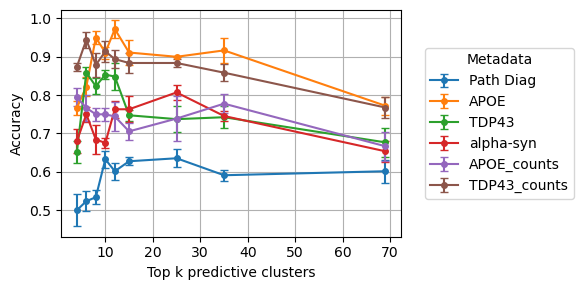

In [204]:
colors = plt.get_cmap('tab10')  # Use Seaborn's 'husl' palette
plt.figure(figsize=(6, 3))
annoPlotNames=['Path Diag','APOE','TDP43','alpha-syn','APOE_counts','TDP43_counts']
for i in range(resComp_mean.shape[0]):
    plt.errorbar(threshTest, resComp_mean[i], yerr=resComp_std[i], label=annoPlotNames[i], 
                 color=colors.colors[i], fmt='-o', capsize=3, capthick=1, markersize=4)
plt.xlabel("Top k predictive clusters")
plt.ylabel("Accuracy")
plt.legend(title="Metadata", loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.grid(True)
plt.tight_layout()
plt.savefig('figs5a.pdf')
plt.show()
# plt.plot(threshTest,resComp_mean[0])

In [27]:
#subset neighborhood plot by predictive clusters
with open('/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall/leiden_res5', 'rb') as output:
    currPartition=pickle.load(output).astype('U300')
    
with open(os.path.join(savedir_baseline,'finalPartition'), 'rb') as output:
    finalPartition=pickle.load(output)
clusterByLevels=np.char.split(finalPartition,'_')
levelcounts=[len(x) for x in clusterByLevels]
clusterLevels={}
clusterLevels_names={}
for currLevel in range(1,np.max(levelcounts)+1):
    currPartition=np.repeat('',finalPartition.size).astype('U10')
    for e in range(finalPartition.size):
        if levelcounts[e]<currLevel:
            continue
        currPartition[e]=clusterByLevels[e][currLevel-1]
    clusterLevels[currLevel]=currPartition
    if currLevel==1:
        clusterLevels_names[currLevel]=np.copy(currPartition)
    else:
        clusterLevels_names[currLevel]=np.copy(clusterLevels_names[currLevel-1])
        clusterLevels_names[currLevel][currPartition!='']=np.char.add(np.char.add(clusterLevels_names[currLevel][currPartition!=''],np.repeat('_',np.sum(currPartition!=''))),currPartition[currPartition!=''])
    
with open(os.path.join(savedir_processed,'allPatientID'), 'rb') as output:
    allPatientID=pickle.load(output)
    
with open('/data/xzhang/neuro/results/clusterVal/0DAPI/spatial/distByImg', 'rb') as output:
    distByImg=pickle.load(output)
    
spatialRegions=[300,650,1000]

In [28]:
clusterUnique,clusterUnique_size=np.unique(finalPartition_keep_input,return_counts=True)
clusterUnique_sizeFilter=clusterUnique[clusterUnique_size>150]
cluster2plot_sizeFilter=np.intersect1d(clusterUnique_sizeFilter,cluster2plot_passed)
print(cluster2plot_sizeFilter.size)
cluster2plot_sizeFilter

29


array([ 0.,  1.,  2.,  3.,  4.,  7., 11., 13., 14., 17., 18., 19., 20.,
       21., 28., 32., 34., 36., 39., 53., 62., 66., 74., 82., 84., 85.,
       94., 97., 99.])

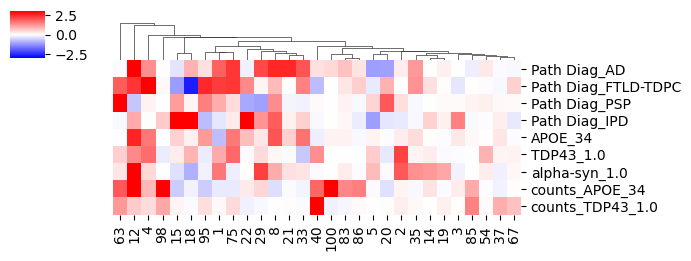

In [193]:
cluster2plot_passed,igIdx,_=np.intersect1d(np.unique(finalPartition_keep_input[finalPartition_keepIdx]),cluster2plot_sizeFilter,return_indices=True)

sampleNames_plot_all = np.concatenate((sampleNames_plot,sampleNames_plot_counts))
vabs = 3

data = np.concatenate((igPlotAll_mean[:,1:][:, igIdx],igPlotAll_mean_counts[:, igIdx]))  # Subset only passing threshold columns

# col_linkage = linkage(data.T, method='ward')  # Clustering columns (features)

# Create clustermap
heatmap=sns.clustermap(data, cmap="bwr", vmin=-vabs, vmax=vabs, col_cluster=True, row_cluster=False,
               xticklabels=clusterUnique.astype(int)[1:][igIdx]+1, yticklabels=sampleNames_plot_all, 
               figsize=(7, 2.6), method='ward')

plt.savefig(os.path.join(plotIGsavepath_thresh,'plots','heatmapIG.pdf'))
plt.show()


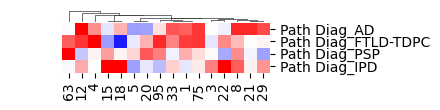

In [245]:
t=8
cluster2plot_diag=[]
anno='Path Diag'
#     t=threshSet[anno]
for c2pIdx in annoIGidx[anno]:    
    cluster2plot_diag=np.concatenate((cluster2plot_diag,clusterUnique.astype(int)[np.argsort(np.abs(igPlotAll_mean[c2pIdx]))[-t:]]))

clusterUnique_sizeFilter_anno=clusterUnique[clusterUnique_size>150]
cluster2plot_sizeFilter_diag=np.intersect1d(clusterUnique_sizeFilter_anno,cluster2plot_diag)
cluster2plot_passed_diag,igIdx,_=np.intersect1d(np.unique(finalPartition_keep_input[finalPartition_keepIdx]),cluster2plot_sizeFilter_diag,return_indices=True)

sampleNames_plot_all = np.concatenate((sampleNames_plot,sampleNames_plot_counts))
vabs = 3

data = igPlotAll_mean[:4,1:][:4, igIdx]

# col_linkage = linkage(data.T, method='ward')  # Clustering columns (features)

# Create clustermap
heatmap=sns.clustermap(data, cmap="bwr", vmin=-vabs, vmax=vabs, col_cluster=True, row_cluster=False,
               xticklabels=clusterUnique.astype(int)[1:][igIdx]+1, yticklabels=sampleNames_plot_all[:4], 
               figsize=(4.5, 1.2), method='ward')

heatmap.cax.set_visible(False)

plt.savefig(os.path.join(plotIGsavepath_thresh,'plots','heatmapIG_pathdiag.pdf'))
plt.show()


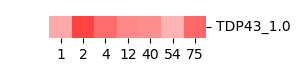

In [259]:
t=8
cluster2plot_diag=[]
anno='TDP43'
#     t=threshSet[anno]
for c2pIdx in annoIGidx[anno]:    
    cluster2plot_diag=np.concatenate((cluster2plot_diag,clusterUnique.astype(int)[np.argsort(np.abs(igPlotAll_mean[c2pIdx]))[-t:]]))

clusterUnique_sizeFilter_anno=clusterUnique[clusterUnique_size>150]
cluster2plot_sizeFilter_diag=np.intersect1d(clusterUnique_sizeFilter_anno,cluster2plot_diag)
cluster2plot_passed_diag,igIdx,_=np.intersect1d(np.unique(finalPartition_keep_input[finalPartition_keepIdx]),cluster2plot_sizeFilter_diag,return_indices=True)

sampleNames_plot_all = np.concatenate((sampleNames_plot,sampleNames_plot_counts))
vabs = 3

data = igPlotAll_mean[[5],1:][:, igIdx]

# col_linkage = linkage(data.T, method='ward')  # Clustering columns (features)

# Create clustermap
heatmap=sns.clustermap(data, cmap="bwr", vmin=-vabs, vmax=vabs, col_cluster=False, row_cluster=False,
               xticklabels=clusterUnique.astype(int)[1:][igIdx]+1, yticklabels=sampleNames_plot_all[[5]], 
               figsize=(2.5, 1.0), method='ward')
heatmap.cax.set_visible(False)

# Rotate row labels to horizontal
heatmap.ax_heatmap.set_yticklabels(
    heatmap.ax_heatmap.get_yticklabels(),
    rotation=0,
    ha='left',
    va='center'
)

plt.savefig(os.path.join(plotIGsavepath_thresh,'plots','heatmapIG_tdp43.pdf'),bbox_inches='tight')
plt.show()


In [83]:
corder=heatmap.dendrogram_col.reordered_ind

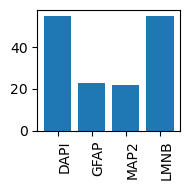

In [132]:
valtypePlot_bar=np.zeros(stains.size)
for cidx in range(finalPartition_keep.size):
    if finalPartition_keep[cidx]!=-1:
        valtype_i=valtypes_level1_df['val_stain'].loc[finalPartition_keep[cidx]].split(' ')
        for valtype_ij in valtype_i:
            valtypePlot_bar[stains==valtype_ij]+=1

    
fig, ax = plt.subplots(figsize=(2,2))
plt.bar(np.arange(stains.size),valtypePlot_bar)

# Add the legend to the plot
ax.set_xticks(np.arange(valtypePlot_bar.shape[0]))
ax.set_xticklabels(stains)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")
fig.tight_layout()
plt.savefig(os.path.join(savedir_baseline,'clusterPlots','valtype_bar.pdf'))
plt.show()

Path Diag_AD
[ 0 -1 32 28 74 20  7 11]
Path Diag_FTLD-TDPC
[62  0 74 11 94 17 -1  3]
Path Diag_PSP
[21 -1 28 14  7 94 19 62]
Path Diag_IPD
[ 4 28 -1  2  7 21 14 17]
APOE_34
[21  0 94 74  3 32  7 11]
TDP43_1.0
[53  0 39 11 -1  3 74  1]
alpha-syn_1.0
[18 -1 13 34  0  1 28 11]


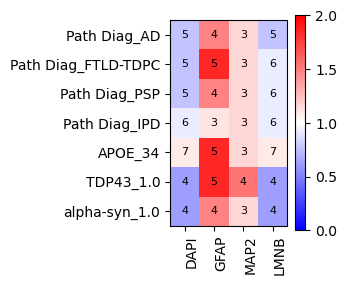

In [145]:
k=8
valtypePlot_predCounts=np.zeros((sampleNames_plot.size,stains.size))

for catIdx in range(sampleNames_plot.size):
    cat=sampleNames_plot[catIdx]
    print(cat)
    topk=clusterUnique[np.argsort(np.abs(igPlotAll_mean[catIdx]))[-k:]]
    print(topk)
    
    for cidx in range(k):
        if topk[cidx]!=-1:
            valtype_i=valtypes_level1_df['val_stain'].loc[topk[cidx]].split(' ')
            for valtype_ij in valtype_i:
                valtypePlot_predCounts[catIdx,stains==valtype_ij]+=1

    
fig, ax = plt.subplots(figsize=(3,3))
im=ax.imshow(valtypePlot_predCounts/(valtypePlot_bar.reshape(1,-1)/68*k),cmap='bwr',vmin=0,vmax=2)

for i in range(valtypePlot_predCounts.shape[0]):
    for j in range(valtypePlot_predCounts.shape[1]):
        text = f"{valtypePlot_predCounts[i, j]:.0f}"  # Convert to integer format
        ax.text(j, i, text, ha="center", va="center", color="black", fontsize=8)


# Add the legend to the plot
ax.set_xticks(np.arange(valtypePlot_predCounts.shape[1]))
ax.set_xticklabels(stains)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")
ax.set_yticks(np.arange(valtypePlot_predCounts.shape[0]))
ax.set_yticklabels(sampleNames_plot)
plt.colorbar(im)
fig.tight_layout()
plt.savefig(os.path.join(plotIGsavepath_thresh,'plots','valtype_frac.pdf'))
plt.show()

Path Diag_AD APOE_34


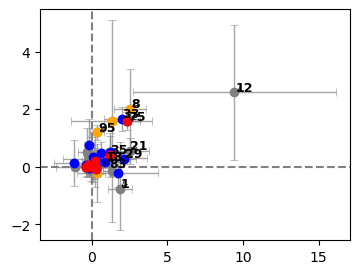

PearsonRResult(statistic=0.6748513187932939, pvalue=2.0360654882004055e-10)
Path Diag_AD TDP43_1.0


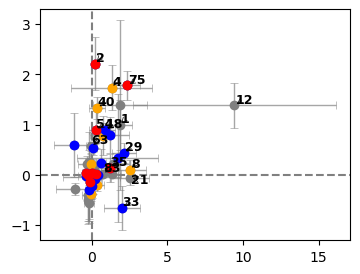

PearsonRResult(statistic=0.4230777513778169, pvalue=0.0002925490310368342)
Path Diag_AD alpha-syn_1.0


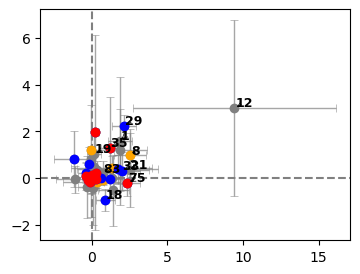

PearsonRResult(statistic=0.5918362944273561, pvalue=8.523758422199223e-08)
Path Diag_FTLD-TDPC APOE_34


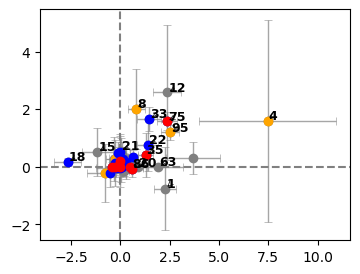

PearsonRResult(statistic=0.5005301881059403, pvalue=1.1883402275652845e-05)
Path Diag_FTLD-TDPC TDP43_1.0


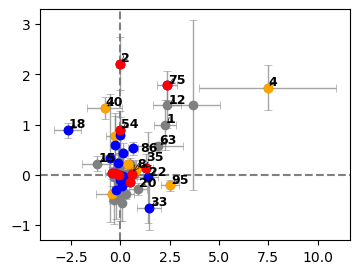

PearsonRResult(statistic=0.3900632815712581, pvalue=0.0009223358564087336)
Path Diag_FTLD-TDPC alpha-syn_1.0


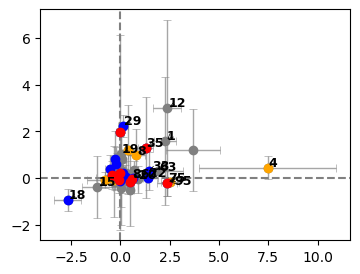

PearsonRResult(statistic=0.3309431036972892, pvalue=0.005477383991993938)
Path Diag_PSP APOE_34


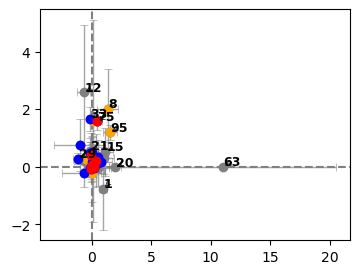

PearsonRResult(statistic=-0.03851610781617758, pvalue=0.7533611523680169)
Path Diag_PSP TDP43_1.0


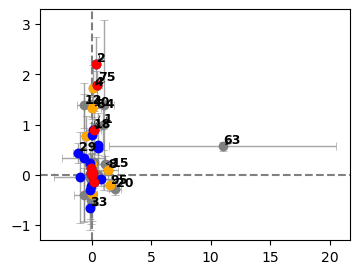

PearsonRResult(statistic=0.10382078992212569, pvalue=0.39591321694601045)
Path Diag_PSP alpha-syn_1.0


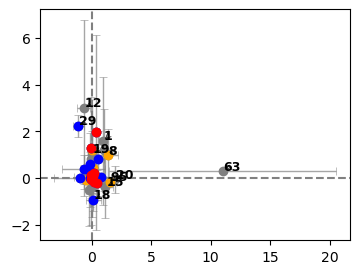

PearsonRResult(statistic=-0.03044505822325615, pvalue=0.8038767081893182)
Path Diag_IPD APOE_34


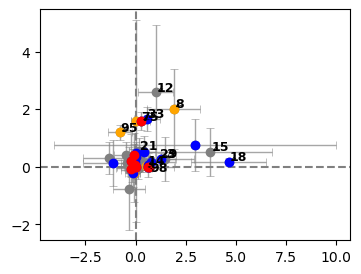

PearsonRResult(statistic=0.25373985062343757, pvalue=0.035397693259445424)
Path Diag_IPD TDP43_1.0


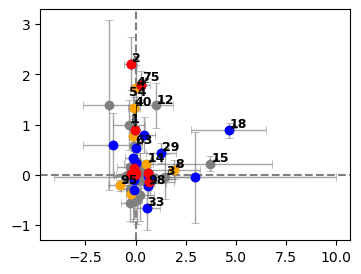

PearsonRResult(statistic=0.012234581135951645, pvalue=0.9205228463219987)
Path Diag_IPD alpha-syn_1.0


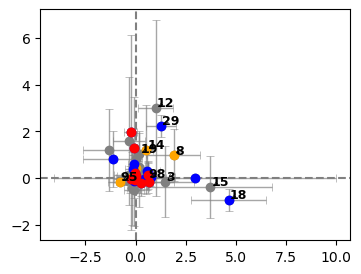

PearsonRResult(statistic=-0.11159116185918816, pvalue=0.361312443865562)


In [190]:
map2idx=markersum_map2>(np.mean(markersum_map2)+np.std(markersum_map2))*0.8
gfapidx=markersum_gfap>(np.mean(markersum_gfap)+np.std(markersum_gfap))*0.8
bothidx=np.logical_and(map2idx,gfapidx)

offset = 0.05  # Base shift for repositioning
min_dist = 0.3  # Minimum allowable distance between labels

def is_too_close(x_pos, y_pos, labeled_points, threshold=min_dist):
    """Check if a label is too close to an existing one"""
    for (lx, ly) in labeled_points:
        if np.sqrt((x_pos - lx) ** 2 + (y_pos - ly) ** 2) < threshold:
            return True
    return False

for p in sampleNames_plot:
    if 'Path Diag' not in p:
        continue
    x_values = igPlotAll_mean[sampleNames_plot == p].flatten()
    x_err = igPlotAll_std[sampleNames_plot == p].flatten()
    
    plabel_idx=np.repeat(False,igPlotAll_mean.shape[1])
    plabel_idx[np.logical_and(x_values>0.5,x_values-x_err>0)]=True
    plabel_idx[np.logical_and(x_values<-0.5,x_values+x_err<0)]=True
    
    for m in sampleNames_plot:
        if 'Path Diag' in m:
            continue
        print(p,m)
        
        y_values = igPlotAll_mean[sampleNames_plot == m].flatten()
        y_err = igPlotAll_std[sampleNames_plot == m].flatten()
        
        mlabel_idx=np.repeat(False,igPlotAll_mean.shape[1])
        mlabel_idx[np.logical_and(y_values>0.5,y_values-y_err>0)]=True
        mlabel_idx[np.logical_and(y_values<-0.5,y_values+y_err<0)]=True
        
        mlabel_idx=np.logical_or(plabel_idx,mlabel_idx)
        

        fig, ax = plt.subplots(figsize=(4,3))
        plt.errorbar(x_values, y_values, xerr=x_err, yerr=y_err, fmt='.', capsize=3, 
                     capthick=0.5, elinewidth=1, alpha=0.7, c='gray',zorder=0)
        plt.scatter(x_values, y_values,c='gray')
        plt.scatter(x_values[map2idx], y_values[map2idx],c='orange')
        plt.scatter(x_values[gfapidx], y_values[gfapidx],c='blue')
        plt.scatter(x_values[bothidx], y_values[bothidx],c='red')
        
#         for l in range(np.sum(mlabel_idx)):
#             if clusterUnique.astype(int)[mlabel_idx][l] in cluster2plot_passed:
#                 ax.text(x_values[mlabel_idx][l], y_values[mlabel_idx][l], clusterUnique.astype(int)[mlabel_idx][l], fontsize=9, fontweight='bold', color='black', ha='left')
        labeled_points = []

        for l in range(np.sum(mlabel_idx)):
            cluster_id = clusterUnique.astype(int)[mlabel_idx][l]
            if cluster_id in cluster2plot_passed:
                x_pos = x_values[mlabel_idx][l]
                y_pos = y_values[mlabel_idx][l]

                # Adjust position if too close to another label
                while is_too_close(x_pos, y_pos, labeled_points):
                    x_pos += np.random.choice([-offset, offset])  # Random shift left/right
                    y_pos += np.random.choice([-offset, offset])  # Random shift up/down

                ax.annotate(str(cluster_id+1), (x_values[mlabel_idx][l], y_values[mlabel_idx][l]),
                            xytext=(x_pos + offset, y_pos + offset), 
                            textcoords='data',
                            fontsize=9, fontweight='bold', color='black',
                            arrowprops=dict(arrowstyle="->", lw=0.5, color='black'))

                labeled_points.append((x_pos, y_pos))  # Store adjusted label position

        ax.axhline(y=0,color='gray',linestyle='--',zorder=0)
        ax.axvline(x=0,color='gray',linestyle='--',zorder=0)
        plt.savefig(os.path.join(plotIGsavepath_thresh,'plots',p+'_'+m+'_shifted.pdf'))
        plt.show()
        print(stats.pearsonr(x_values.flatten(),y_values.flatten()))

In [103]:


# Function to traverse from bottom-up
def traverse_dendrogram(linkage_matrix):
    num_leaves = linkage_matrix.shape[0] + 1  # Number of original data points
    cluster_map = {i: ([i],i,i) for i in range(num_leaves)}  # Initialize leaves

    for i, (c1, c2, dist, n) in enumerate(linkage_matrix):
        c1, c2 = int(c1), int(c2)
        new_cluster = num_leaves + i
        cluster_map[new_cluster] = (cluster_map[c1][0] + cluster_map[c2][0],c1,c2)
#         print(f"Merge: {c1} + {c2} -> {new_cluster}, Elements: {cluster2plot_sizeFilter[cluster_map[new_cluster][0]]}")

    return cluster_map



In [104]:
def getclusters(root,linkage, clustermap,corr, mincorr,meancorr,minsize):
    cluster,c1,c2=clustermap[root]
    if len(cluster)<minsize:
        return
    corr_curr=np.array(corr.iloc[cluster,cluster])
    np.fill_diagonal(corr_curr,np.nan)
    corr_valid=corr_curr[np.isfinite(corr_curr)]
    min_curr=np.min(corr_valid)
    mean_curr=np.mean(corr_valid)
#     print('min',min_curr)
#     print('mean',mean_curr)
#     print(cluster)
    
    if min_curr>mincorr and mean_curr>meancorr:
        return cluster
    
    return getclusters(c1,linkage, clustermap,corr, mincorr,meancorr,minsize),getclusters(c2,linkage, clustermap,corr, mincorr,meancorr,minsize)

In [105]:
def extract_lists(node):
    """Recursively extract all lists from the nested structure."""
    if isinstance(node, list):
        return [node]
    elif isinstance(node, tuple):
        extracted = []
        for item in node:
            extracted.extend(extract_lists(item))
        return extracted
    return []


Path Diag
level  1
subcluster -1
76996
AD


/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


neighborcorr
56
[array([21.,  7.,  4., 17., 99., 11., 19.]), array([ 2., 34., 82.,  1., 28., 53.]), array([18., 13.,  3., 39.]), array([36., 66., 84.,  0., 74.])]
vabs  5.22881869049588
Control


/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


neighborcorr
56
[array([11., 82.,  2., 20.]), array([39., 36., 18., 66.,  7., 14.]), array([34., 21., 84., 74., 85.]), array([94.,  4., 32.]), array([62., 19., 53.]), array([17.,  1., 28.])]
vabs  5.321928094887363
FTLD-TDPC
neighborcorr
56
[array([ 3., 14., 13., 39., 66., 18.,  0., 36.]), array([32.,  7., 28., 21.,  1.,  4., 17., 11., 84.])]
vabs  4.832890014164742
IPD
neighborcorr
56
[array([ 3.,  0., 13.]), array([18., 39., 82., 66., 94.]), array([34.,  7., 17., 14., 32., 36., 20.,  4., 21.])]
vabs  5.614709844115208
PSP
neighborcorr
56
[array([14., 39.,  3., 13., 66.,  0., 18., 82., 36., 85.]), array([94., 32., 28., 34.]), array([ 1., 21.,  4., 17.])]
vabs  5.0
AD


/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


neighborcorr
56
[array([ 1., 34., 53., 28.,  4.,  7., 17., 21., 11., 82., 99., 97., 84.,
       19., 32.]), array([36., 66., 39.,  3., 13.])]
vabs  5.044394119358453
Control


/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


neighborcorr
56
[array([74.,  0., 13., 36., 39., 66.,  3., 82.]), array([ 2., 21., 85.]), array([17.,  1.,  4., 28., 97.]), array([19., 11., 53.]), array([34., 20., 99.])]
vabs  4.754887502163468
FTLD-TDPC
neighborcorr
56
[array([ 0., 18., 66., 14., 13.,  3., 39., 19., 36., 74.]), array([84., 99., 11., 97.,  7.,  4., 17.,  1., 28., 21., 32.])]
vabs  5.39231742277876
IPD


KeyboardInterrupt: 

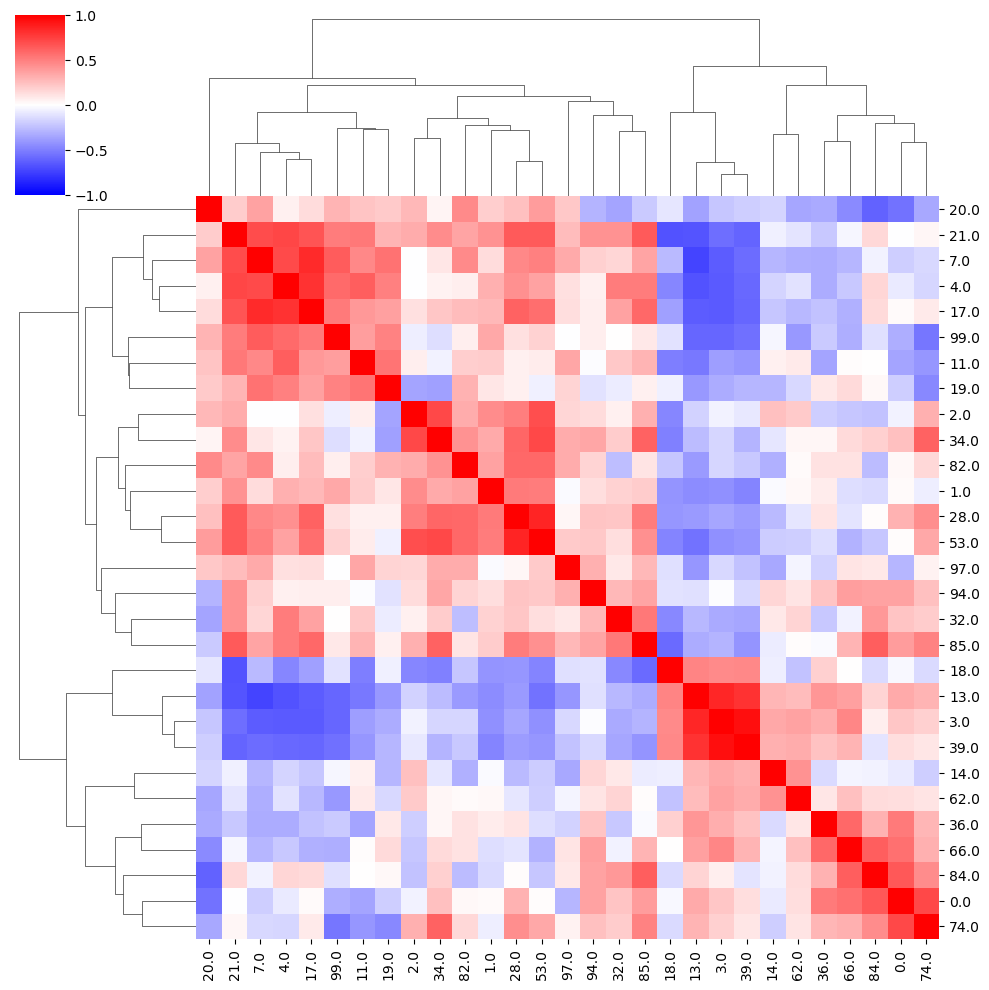

<Figure size 1000x800 with 0 Axes>

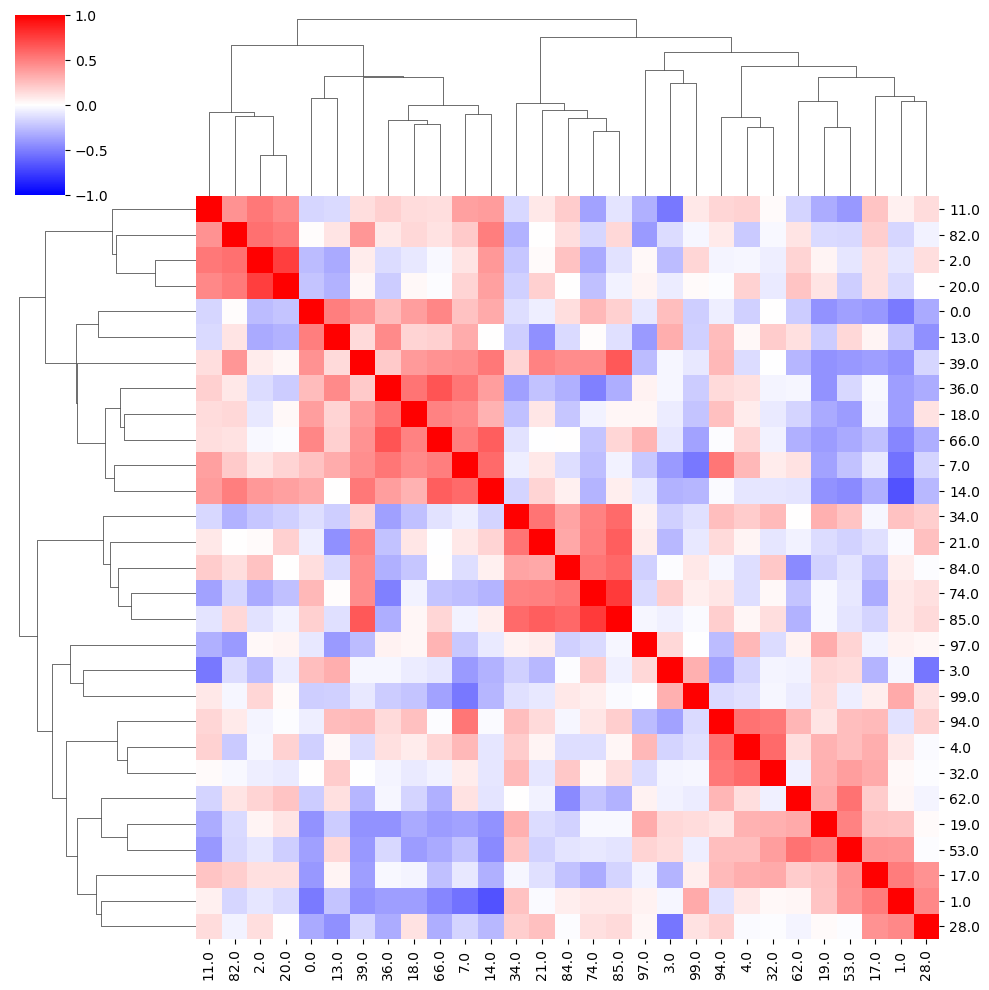

<Figure size 1000x800 with 0 Axes>

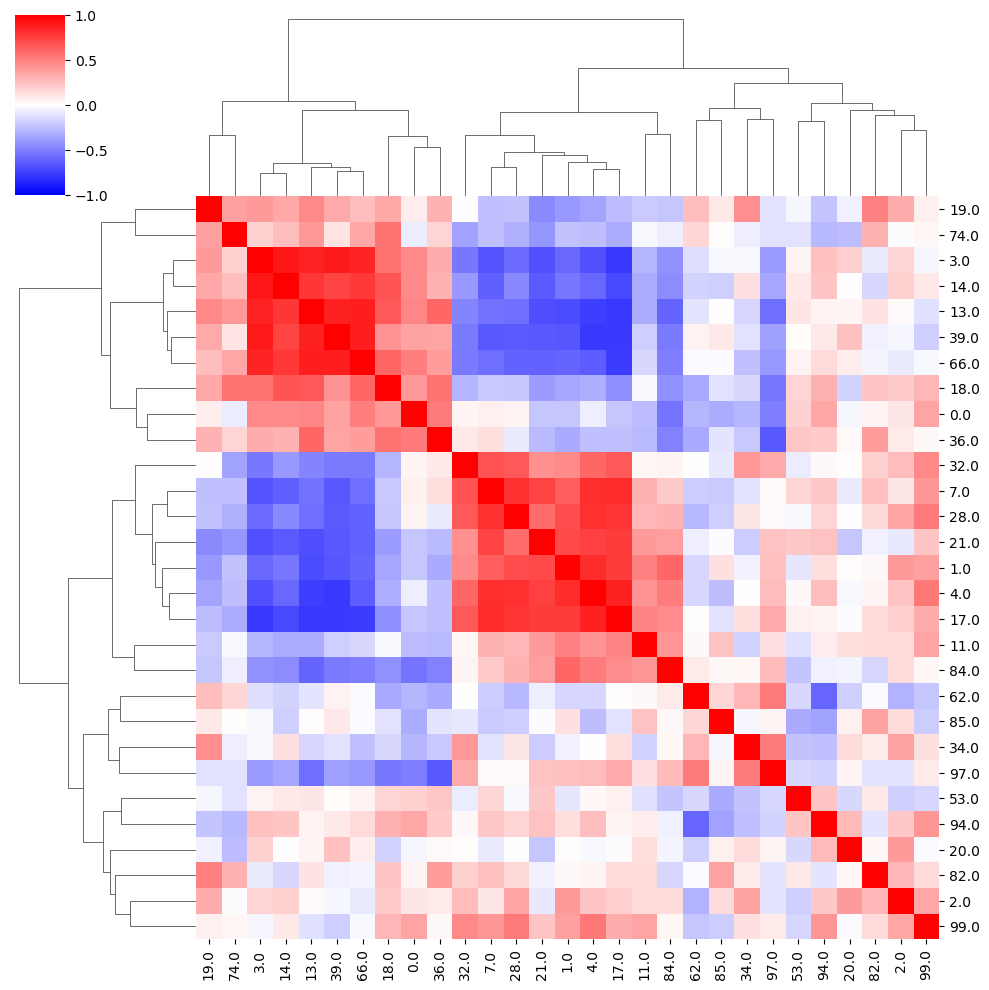

<Figure size 1000x800 with 0 Axes>

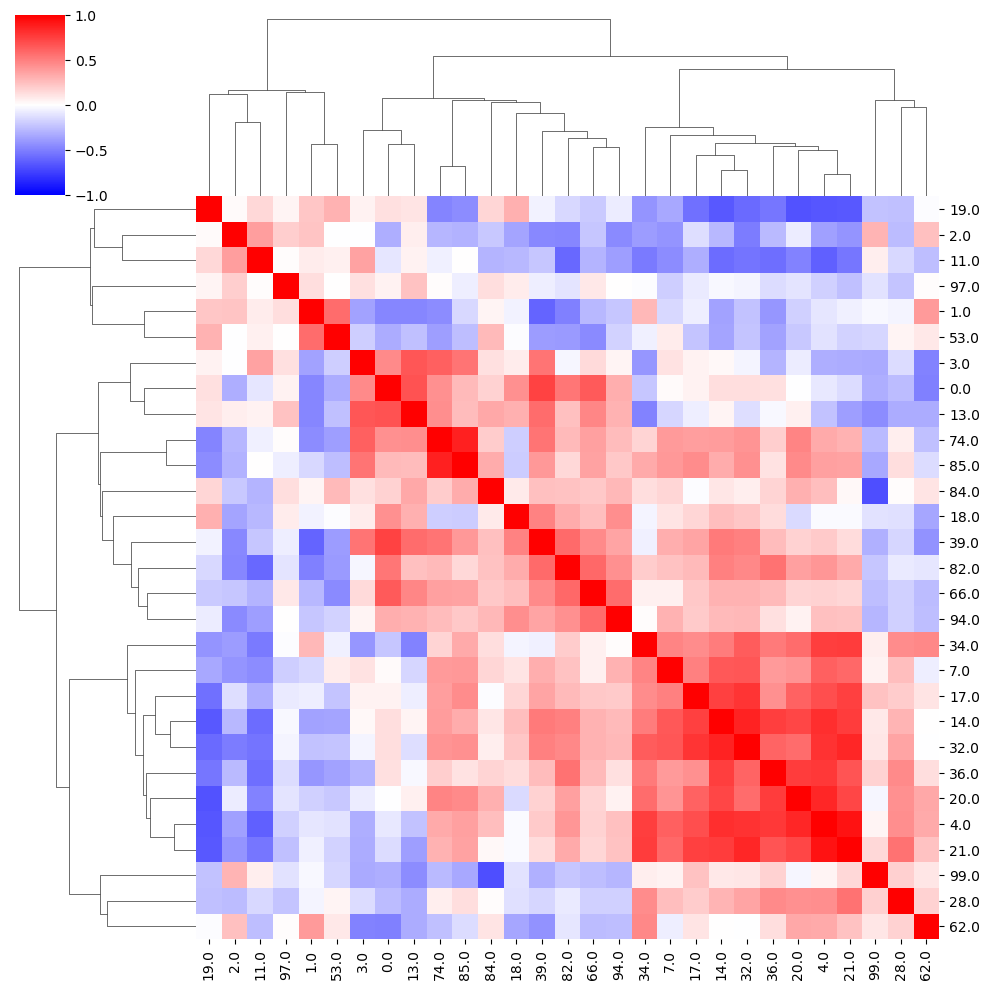

<Figure size 1000x800 with 0 Axes>

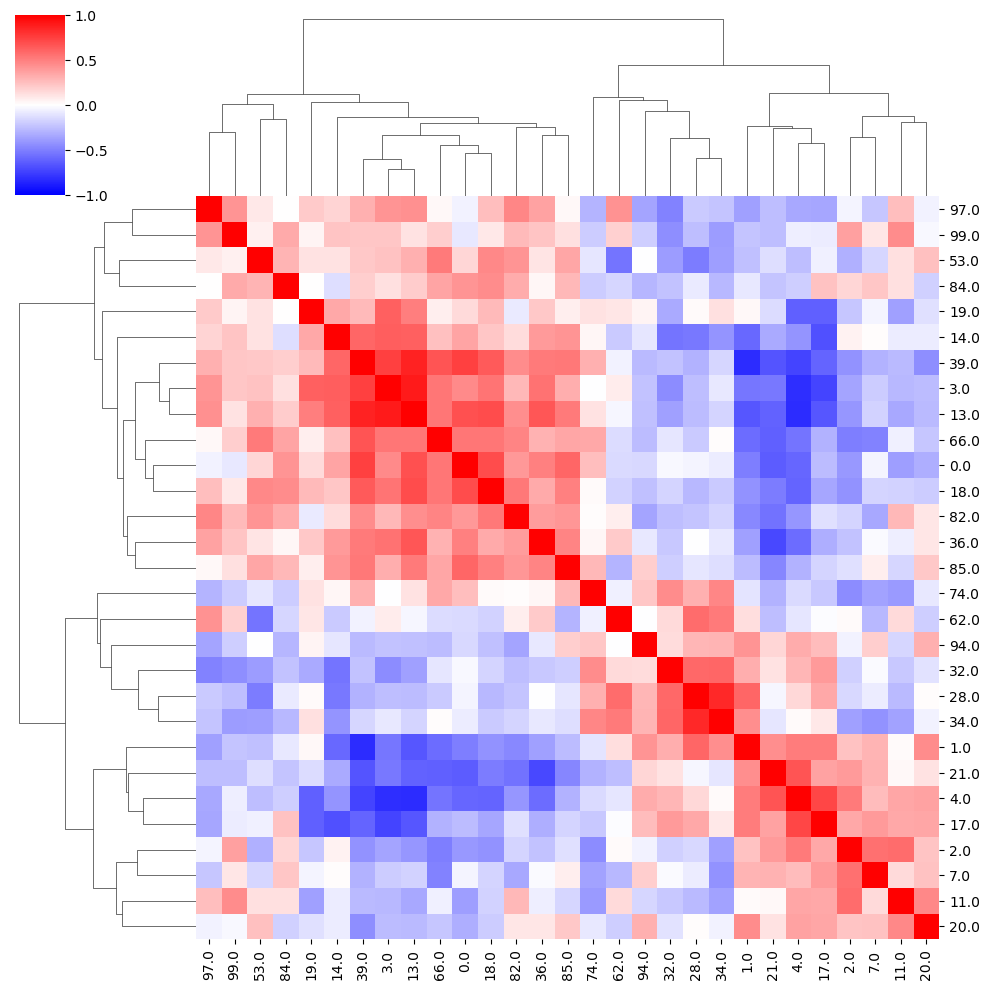

<Figure size 1000x800 with 0 Axes>

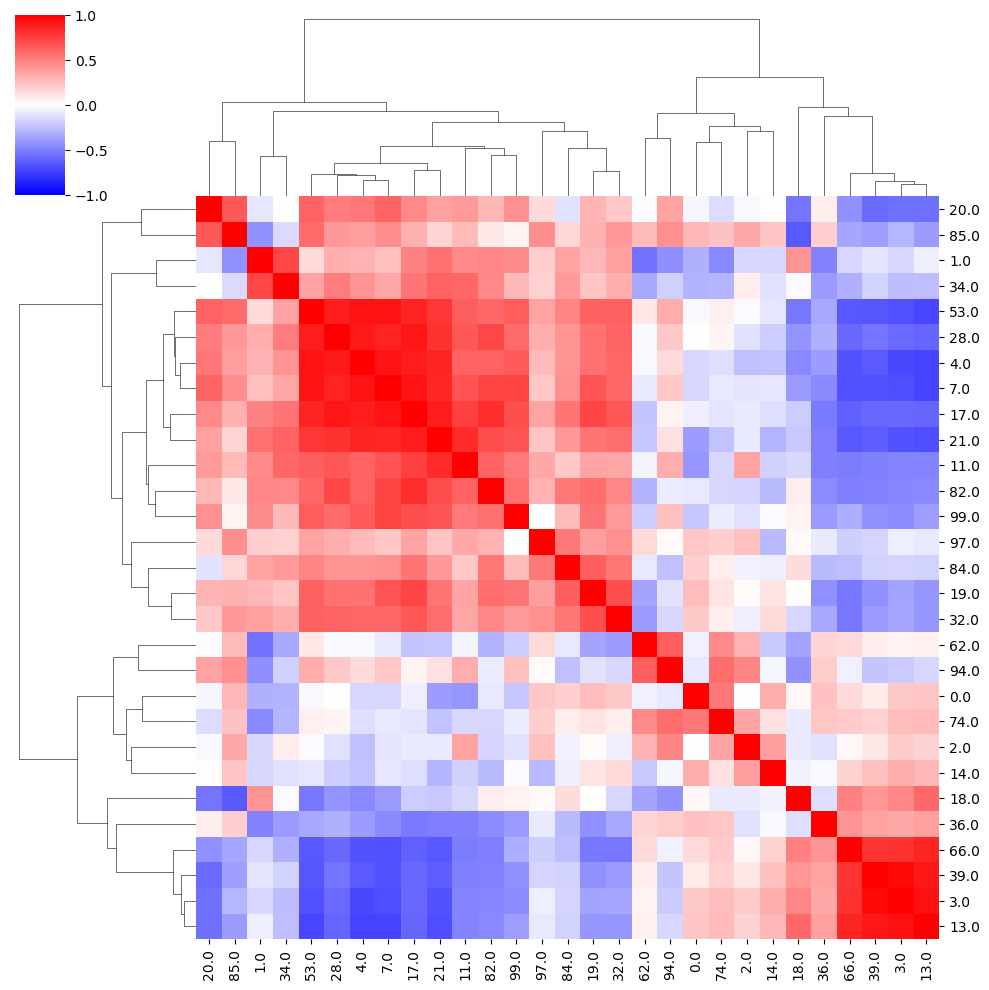

<Figure size 1000x800 with 0 Axes>

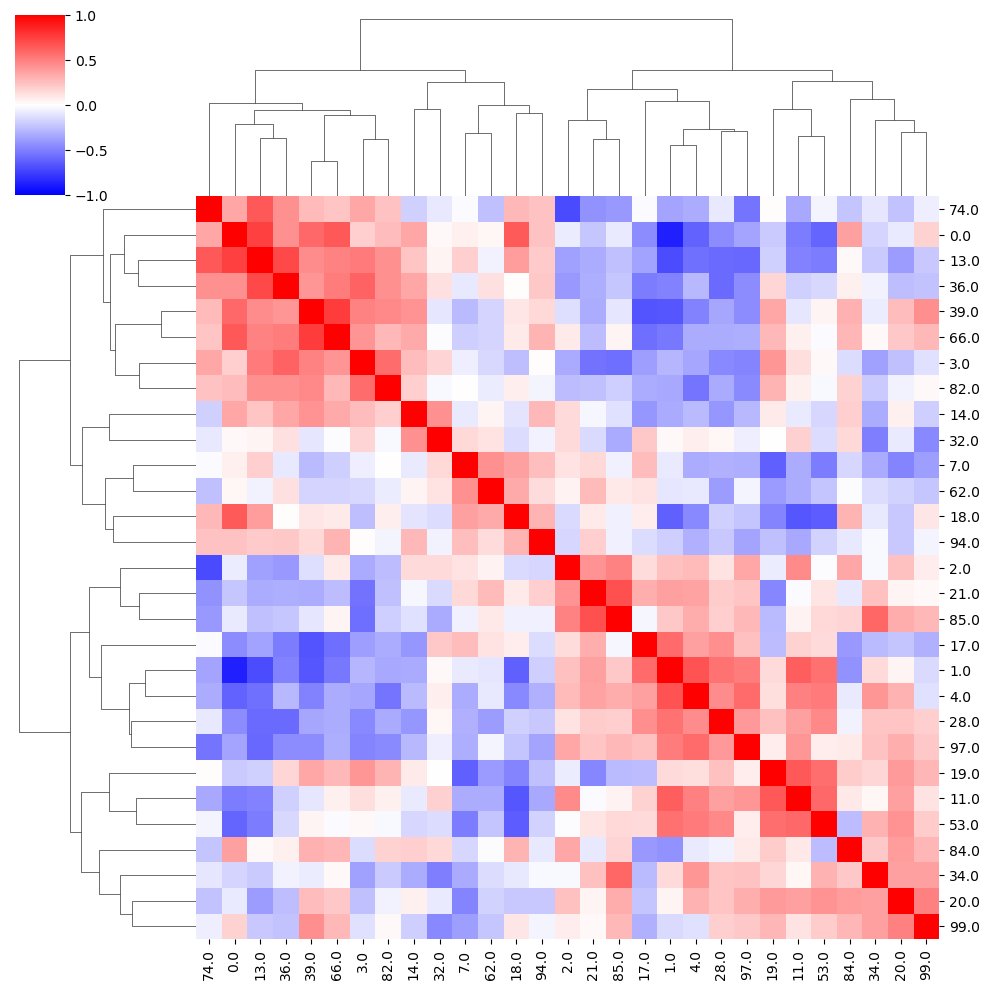

<Figure size 1000x800 with 0 Axes>

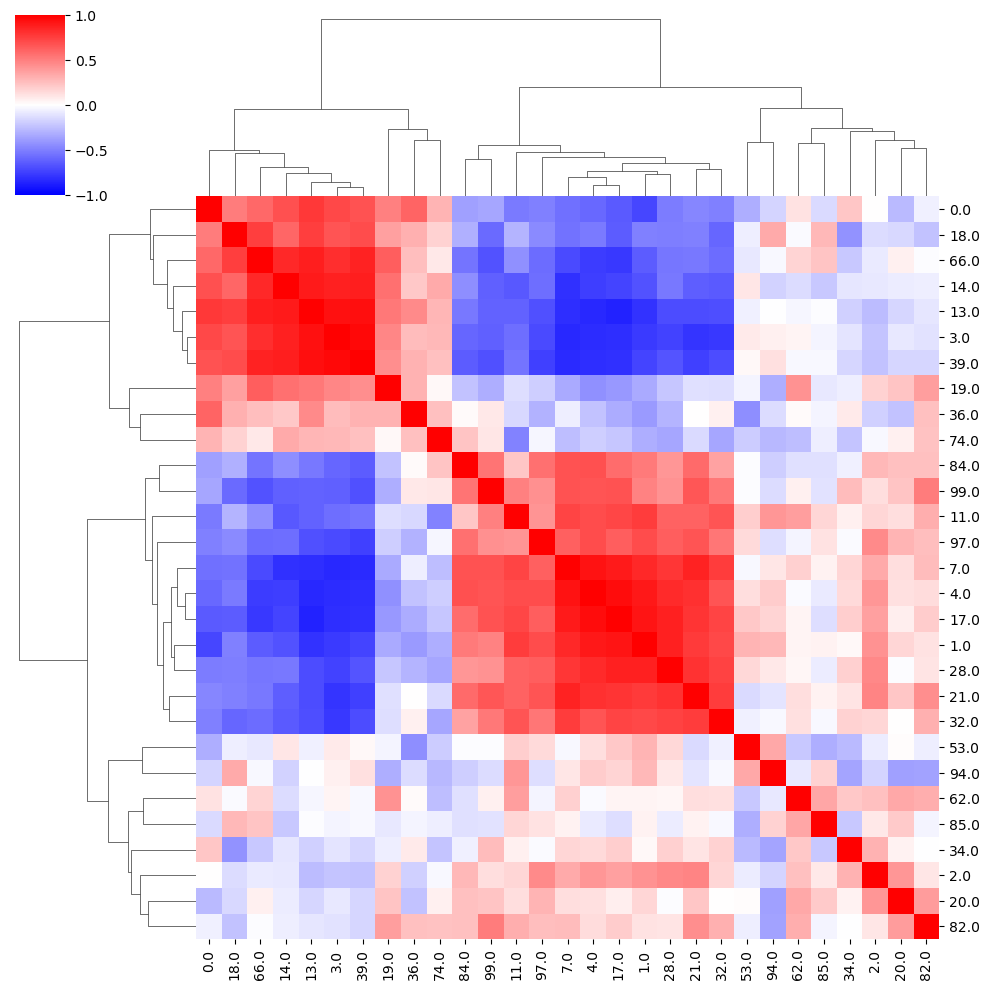

<Figure size 1000x800 with 0 Axes>

In [89]:
import matplotlib.colors as mcolors
mincorr,meancorr,minsize=0,0.4,3
annoSpatial=['Path Diag', 'TDP43', 'APOE','alpha-syn']
# annoSpatial=['alpha-syn']
minCells=20
spatialTestLevel=1
updateExisting=False

bgcolor='gray'
cluster_colors = [mcolors.to_hex(color) for color in sns.color_palette("husl", 6)]

# with open('/data/xzhang/neuro/results/jointClustering/baseline/res5/clusterPlots/ls_cc_level1Val', 'rb') as output:
#     ls_cc_fin=pickle.load( output)

for mIdx in range(len(annoSpatial)):
    currAnno=annoSpatial[mIdx]
    print(currAnno)
    with open('/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall/leiden_res5', 'rb') as output:
        nextPartition=pickle.load(output).astype('U300')
    finalPartition=np.repeat('-1',currPartition.size).astype('U300')
    
    clustersavepath={'-1':savedir_baseline}
    clusterRes=5
    subclusterRes=1

    for currLevel in range(1,np.max(levelcounts)+1):
        if currLevel==2:
            break
        nextPartition=nextPartition.astype(int).astype('U300')

        print('level ',currLevel)
        nextPartition_passed=clusterLevels[currLevel]
        nextPartition_passedIdx=np.logical_and(nextPartition_passed!='-1',nextPartition_passed!='')

        for p in np.unique(finalPartition): 
            if np.unique(nextPartition_passed[finalPartition==p]).size==1:
                print(np.unique(nextPartition_passed[finalPartition==p]))
                continue
            print('subcluster',p)
            p_passedIdx=np.logical_and(finalPartition==p,nextPartition_passedIdx)

#             plotsavepath_curr=os.path.join(clustersavepath[p],'clusterPlots_bymeta_igFilter')
            plotsavepath_curr=os.path.join(clustersavepath[p],'clusterPlots_bymeta_igFilter_thresh8')
            plotsavepath_sp_curr=os.path.join(clustersavepath[p],'clusterPlots')
            if not os.path.exists(plotsavepath_curr):
                os.mkdir(plotsavepath_curr)
            plotsavepath_curr=os.path.join(plotsavepath_curr,currAnno)
            if not os.path.exists(plotsavepath_curr):
                os.mkdir(plotsavepath_curr)
            c_prevIdx=finalPartition==p

            finalPartition_keep=np.unique(nextPartition[p_passedIdx].astype(int))
            
            #get meta
            allPatientID_p=allPatientID[p_passedIdx]
            meta_allcells=meta.loc[allPatientID_p][currAnno].to_numpy().astype(str)
            #filter cells with na
            cellIdx=np.logical_and(meta_allcells!='na',meta_allcells!='nan')
            print(np.sum(cellIdx))

            meta_allcells=meta_allcells[cellIdx]
            meta_allcells_unique=np.unique(meta_allcells)


            #spatial vs cluster
            allImgNames_p=allImgNames[p_passedIdx]
            distByImg_p={}
            for img_i in np.unique(allImgNames_p):
#                 print(img_i)
                distByImg_p[img_i]=distByImg[img_i][p_passedIdx[allImgNames==img_i]]

            clusterIdx_curr=clusterLevels_names[spatialTestLevel]!='-1'
        
            ls_cc_fin_cat={}
            for sr in range(len(spatialRegions)):
                
                with open(os.path.join(plotsavepath_sp_curr,'neighborhood_allCells_'+str(spatialRegions[sr])), 'rb') as output:
                    res=pickle.load(output)
                with open(os.path.join(plotsavepath_sp_curr,'neighborhoodRandom_allCells_'+str(spatialRegions[sr])), 'rb') as output:
                    resRand=pickle.load(output)
                with open(os.path.join(plotsavepath_sp_curr,'neighborhoodRandomCluster_allCells_'+str(spatialRegions[sr])), 'rb') as output:
                    resRand_clusterOrder=pickle.load(output)
                with open(os.path.join(plotsavepath_sp_curr,'neighborhood_allCells_counts_'+str(spatialRegions[sr])), 'rb') as output:
                    resCounts_all=pickle.load(output)
                #compare to expected values instead of other clusters
                for catIdx in range(meta_allcells_unique.size):
                    cat_curr=meta_allcells_unique[catIdx]
                    c_currIdx=np.arange(allImgNames_p.size)[cellIdx][meta_allcells==cat_curr]
                    print(cat_curr)

                    res_noNorm=np.copy(res[c_currIdx,:-1]*res[c_currIdx,[-1]].reshape(-1,1))
                    resPlot_bg=np.zeros((finalPartition_keep.size,res_noNorm.shape[1]))
                    for cidx in range(finalPartition_keep.size):
                        c=finalPartition_keep[cidx]
                        if np.sum(nextPartition[c_currIdx]==str(c))==0:
                            continue
                        res_in=np.sum(res_noNorm[nextPartition[p_passedIdx][c_currIdx]==str(c)],axis=0)
                        res_out=np.sum(resRand[:,c_currIdx][resRand_clusterOrder[:,c_currIdx]==c,:-1],axis=0) 
                        resPlot_bg[cidx]=np.log2((res_in+0.1)/(res_out/resRand.shape[0]+0.1))
                        
                    resCounts=np.copy(resCounts_all[c_currIdx])
                    resCountsPlot=np.zeros(finalPartition_keep.size)
                    for cidx in range(finalPartition_keep.size):
                        c=finalPartition_keep[cidx]
                        res_in=np.mean(resCounts[nextPartition[p_passedIdx][c_currIdx]==str(c)])
                        res_out=np.mean(resCounts[nextPartition[p_passedIdx][c_currIdx]!=str(c)])
                        resCountsPlot[cidx]=np.log2(res_in/res_out)
                        
                    if np.sum(np.isfinite(resPlot_bg))<2:
                        continue
                    
                    #filter by predictiveness
                    _,igIdx,_=np.intersect1d(finalPartition_keep,cluster2plot_sizeFilter,return_indices=True)
                    resPlot_bg=resPlot_bg[igIdx][:,igIdx]
                    
                    print('neighborcorr')
                    resPlotDF=pd.DataFrame(np.transpose(resPlot_bg),columns=cluster2plot_sizeFilter)
                    corr = resPlotDF.corr()
                    corr[np.logical_not(np.isfinite(corr))]=0
                    if np.sum(np.array(np.isfinite(corr)))<2:
                        continue
                        
                    cluster_grid = sns.clustermap(corr, method='average', cmap='bwr', vmin=-1, vmax=1, row_cluster=True, col_cluster=True)
                    
                    row_colors=np.repeat(bgcolor,corr.shape[0]).astype('U10')
                    linkage_matrix = cluster_grid.dendrogram_row.linkage
                    cluster_map=traverse_dendrogram(linkage_matrix)
                    print(np.max(list(cluster_map.keys())))
                    rescluster=extract_lists(getclusters(np.max(list(cluster_map.keys())),linkage_matrix, cluster_map,corr, mincorr,meancorr,minsize))
                    for i in range(len(rescluster)):
                        row_colors[rescluster[i]]=cluster_colors[i]
                        rescluster[i]=cluster2plot_sizeFilter[rescluster[i]]
                    with open(os.path.join(plotsavepath_curr,'neighborhood_clusterByCorrBGRand_dendroCorr_'+str(spatialRegions[sr])+cat_curr+'_cluster'), 'wb') as output:
                        pickle.dump(rescluster, output, pickle.HIGHEST_PROTOCOL)
                    print(rescluster)
                    
                    row_order = cluster_grid.dendrogram_row.reordered_ind
#                     row_colors=row_colors[row_order]
                    cluster_grid = sns.clustermap(corr, method='average', cmap='bwr', vmin=-1, vmax=1, row_cluster=True, col_cluster=True,row_colors=row_colors)
                    
                    if currLevel==1:
                        ls_cc_fin_cat[str(spatialRegions[sr])+cat_curr]=np.copy(row_order)
                    reordered_resPlot_bg = resPlot_bg[row_order, :][:, row_order]
                    vabs = np.max(np.absolute(reordered_resPlot_bg[np.isfinite(reordered_resPlot_bg)]))
                    print('vabs ',vabs)
#                     im = cluster_grid.ax_heatmap.imshow(reordered_resPlot_bg, cmap='bwr', vmin=-vabs, vmax=vabs)

#                     cluster_grid.cax.clear()  # Clear the existing colorbar
#                     plt.colorbar(im, cax=cluster_grid.cax)  # Add the new colorbar

                    yticklabels = cluster2plot_sizeFilter.astype(int)[row_order]
                    cluster_grid.ax_heatmap.set_yticks(np.arange(len(yticklabels)))
                    cluster_grid.ax_heatmap.set_yticklabels(yticklabels)
#                     xticklabels = np.unique(clusterLevels_names[spatialTestLevel][clusterIdx_curr].astype(int)).astype(str)[ls_cc_fin_cat[str(spatialRegions[sr])+cat_curr]]
                    cluster_grid.ax_heatmap.set_xticks(np.arange(len(yticklabels)))
                    cluster_grid.ax_heatmap.set_xticklabels(yticklabels)

                    # Rotate x-tick labels for better visibility
                    plt.setp(cluster_grid.ax_heatmap.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

                    plt.savefig(os.path.join(plotsavepath_curr,'neighborhood_clusterByCorrBGRand_dendroCorr_'+str(spatialRegions[sr])+cat_curr+'.pdf'))
                    plt.close()

                    plt.figure(figsize=(10, 8))
                    new_clustermap = sns.clustermap(reordered_resPlot_bg, cmap='bwr', vmin=-vabs, vmax=vabs, row_cluster=False, col_cluster=False)

                    # Set x and y tick labels
                    yticklabels = cluster2plot_sizeFilter.astype(int)[row_order]
#                     xticklabels = np.unique(clusterLevels_names[spatialTestLevel][clusterIdx_curr].astype(int)).astype(str)[ls_cc_fin_cat[str(spatialRegions[sr])+cat_curr]]

                    new_clustermap.ax_heatmap.set_yticks(np.arange(len(yticklabels)))
                    new_clustermap.ax_heatmap.set_yticklabels(yticklabels)
                    new_clustermap.ax_heatmap.set_xticks(np.arange(len(yticklabels)))
                    new_clustermap.ax_heatmap.set_xticklabels(yticklabels)


                    # Rotate x-tick labels for better visibility
                    plt.setp(new_clustermap.ax_heatmap.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
                    new_clustermap.savefig(os.path.join(plotsavepath_curr,'neighborhood_clusterByCorrBGRand_dendro_'+str(spatialRegions[sr])+cat_curr+'.pdf'))
                    plt.close()
                    
                    
                    


#             with open('/data/xzhang/neuro/results/jointClustering/baseline/res5/clusterPlots/ls_cc_level1Val_dendro_'+currAnno+'_igFilter', 'wb') as output:
#                 pickle.dump(ls_cc_fin_cat, output, pickle.HIGHEST_PROTOCOL)


        clusterRes=subclusterRes  

        clustersavepath_new={}
        #subcluster
        nextPartition=np.zeros(nextPartition.size)-1
        for p in np.unique(clusterLevels_names[currLevel]):
            if np.sum(clusterLevels_names[currLevel]==p)<minCells or finalPartition[clusterLevels_names[currLevel]==p][0]==p:
                continue
            print('subcluster',p)

            clustersavepath_new[p]=os.path.join(clustersavepath[finalPartition[clusterLevels_names[currLevel]==p][0]],'subcluster_'+clusterLevels_names[currLevel][clusterLevels_names[currLevel]==p][0])

            with open(os.path.join(clustersavepath_new[p],'leiden'+str(subclusterRes)), 'rb') as output:
                nextPartition[clusterLevels_names[currLevel]==p]=pickle.load(output)

        finalPartition=np.copy(clusterLevels_names[currLevel])
        clustersavepath=clustersavepath_new
    

In [61]:
currAnno='APOE'
with open('/data/xzhang/neuro/results/jointClustering/baseline/res5/clusterPlots/ls_cc_level1Val_dendro_'+currAnno+'_igFilter', 'rb') as output:
    ls_cc_fin_cat=pickle.load(output)
ls_cc_fin_cat

{'30024': array([26,  3,  5, 15, 17,  0,  1, 10, 13,  7, 28, 27, 24, 23, 22, 21, 20,
        19, 18, 16, 12, 11,  8,  2,  6, 14,  9,  4, 25]),
 '30033': array([ 3, 16, 22, 11, 26, 13, 18, 24, 25,  2, 12,  0, 10,  5, 19, 21, 27,
         4, 15, 20,  7,  1, 28, 14,  9, 17, 23,  6,  8]),
 '30034': array([ 6, 11,  1, 28, 14, 13,  5, 19,  4,  9, 15, 25, 27, 12, 16, 23, 10,
         7,  3, 18, 24,  0, 17, 21,  8,  2, 20, 22, 26]),
 '65024': array([ 5, 26,  9, 25,  1, 10, 17, 13,  3,  7,  4, 14, 28, 27, 24, 23, 22,
        21, 20, 19, 18, 16, 12, 11,  8,  2,  6,  0, 15]),
 '65033': array([ 4, 25,  2, 13,  9,  1, 14, 19, 16, 26, 28, 10, 23,  5, 15, 12, 24,
        20, 27,  6, 11,  0,  7, 21,  8, 17, 22,  3, 18]),
 '65034': array([16, 24, 11, 15, 12, 25,  1, 23, 28, 13,  4, 14,  5,  9, 19,  6, 27,
         2, 20, 26, 10, 21,  7,  3, 18, 17, 22,  0,  8]),
 '100024': array([ 4, 25,  1, 14, 17,  9, 10,  5, 26,  3,  7, 13, 15,  0, 28, 27, 24,
        23, 22, 21, 20, 19, 18, 16, 12, 11,  8,  2,  6])

In [79]:

clusterNeigh={}
annoSpatial=['Path Diag', 'TDP43', 'APOE','alpha-syn']
sr=300
for mIdx in range(len(annoSpatial)):
    currAnno=annoSpatial[mIdx]
    print(currAnno)
    plotsavepath_curr=os.path.join(savedir_baseline,'clusterPlots_bymeta_igFilter_thresh8',currAnno)
    for cat_curr in np.unique(meta[currAnno].astype(str)):
        currpath=os.path.join(plotsavepath_curr,'neighborhood_clusterByCorrBGRand_dendroCorr_'+str(sr)+cat_curr+'_cluster')
        if not os.path.exists(currpath):
            continue
        with open(currpath, 'rb') as output:
            rescluster=pickle.load(output)
        if '.0' in cat_curr:
            cat_curr=cat_curr[:-2]
        if currAnno+'_'+cat_curr=='APOE_24':
            continue
        clusterNeigh[currAnno+'_'+cat_curr]=rescluster

Path Diag
TDP43
APOE
alpha-syn


In [211]:
with open(os.path.join(savedir_baseline,'clusterPlots_bymeta_igFilter_thresh8','clusterNeigh'), 'wb') as output:
    pickle.dump(clusterNeigh,output,pickle.HIGHEST_PROTOCOL)

In [147]:
with open(os.path.join(savedir_baseline,'clusterPlots_bymeta_igFilter_thresh8','clusterNeigh'), 'rb') as output:
    clusterNeigh=pickle.load(output)

In [286]:
clusterCounts=0
anno='Path Diag'
for key1 in clusterNeigh.keys(): 
    if anno not in key1:
        continue
    clusterCounts+=len(clusterNeigh[key1])
print(clusterCounts)
clusterComtrx=np.zeros((clusterCounts,clusterCounts)) 
clusterComtrxNames=[None]*clusterCounts
rIdx=0
cIdx=0
for key1 in clusterNeigh.keys():
    if anno not in key1:
        continue
    for c1 in range(len(clusterNeigh[key1])):
        cIdx=0
        clusterComtrxNames[rIdx]=key1+'_'+str(c1)
        c1_ele=clusterNeigh[key1][c1]
        for key2 in clusterNeigh.keys():
            if anno not in key2:
                continue
            for c2 in range(len(clusterNeigh[key2])):
                c2_ele=clusterNeigh[key2][c2]
                clusterComtrx[rIdx,cIdx]=np.intersect1d(c1_ele,c2_ele).size/len(c1_ele)
                cIdx+=1
                
        rIdx+=1
        


18


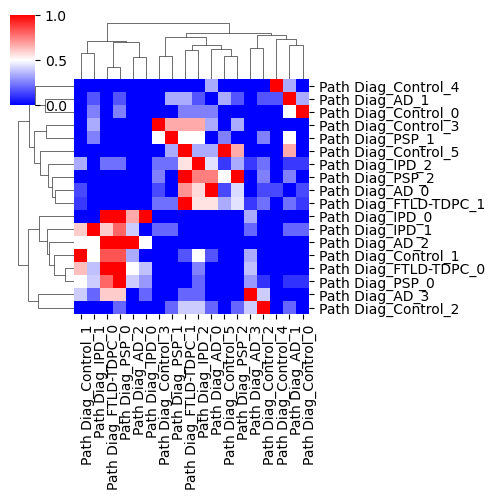

In [287]:
comtrxHM = sns.clustermap(clusterComtrx, cmap='bwr', vmin=0, vmax=1, row_cluster=True, col_cluster=True, xticklabels=clusterComtrxNames, yticklabels=clusterComtrxNames,figsize=(5,5))

# Rotate x-tick labels for better visibility
plt.setp(comtrxHM.ax_heatmap.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
plt.setp(comtrxHM.ax_heatmap.get_yticklabels(), rotation=0, ha="left", rotation_mode="anchor")
plt.show()

In [288]:
#two main neighborhood patterns
# neigh1=['Path Diag_AD_1','TDP43_0_0','Path Diag_FTLD-TDPC_0','Path Diag_PSP_0','Path Diag_IPD_1','APOE_34_1']
# neigh2=['Path Diag_Control_2','Path Diag_IPD_3','Path Diag_IPD_0','TDP43_1_1','Path Diag_PSP_2','Path Diag_FTLD-TDPC_1','APOE_34_0','Path Diag_AD_0','TDP43_0_1']
neigh1=np.unique(np.concatenate((rescluster[0],rescluster_row[0])))
neigh2=np.unique(np.concatenate((rescluster[1],rescluster_row[1])))

neigh1_cluster=[]
for c in neigh1:
    neigh1_cluster.extend(clusterNeigh[c[:-2]][int(c[-1])])
neigh1_cluster=np.unique(neigh1_cluster)

neigh2_cluster=[]
for c in neigh2:
    neigh2_cluster.extend(clusterNeigh[c[:-2]][int(c[-1])])
neigh2_cluster=np.unique(neigh2_cluster)

neighIntersect,neigh1_overlap,neigh2_overlap=np.intersect1d(neigh1_cluster,neigh2_cluster,return_indices=True)
neigh1unique=np.repeat(True,neigh1_cluster.size)
neigh1unique[neigh1_overlap]=False
neigh1_cluster=neigh1_cluster[neigh1unique]

neigh2unique=np.repeat(True,neigh2_cluster.size)
neigh2unique[neigh2_overlap]=False
neigh2_cluster=neigh2_cluster[neigh2unique]
print(neigh1_cluster)
print(neigh2_cluster)

[ 0.  3. 13. 18. 39. 66. 74. 82. 85.]
[19. 20. 34. 99.]


In [289]:
clusterCounts=0
for key1 in clusterNeigh.keys(): 
    clusterCounts+=len(clusterNeigh[key1])
print(clusterCounts)
clusterComtrx=np.zeros((clusterCounts,clusterCounts)) 
clusterComtrxNames=[None]*clusterCounts
rIdx=0
cIdx=0
for key1 in clusterNeigh.keys():
    for c1 in range(len(clusterNeigh[key1])):
        cIdx=0
        clusterComtrxNames[rIdx]=key1+'_'+str(c1)
        c1_ele=clusterNeigh[key1][c1]
        for key2 in clusterNeigh.keys():
            for c2 in range(len(clusterNeigh[key2])):
                c2_ele=clusterNeigh[key2][c2]
                clusterComtrx[rIdx,cIdx]=np.intersect1d(c1_ele,c2_ele).size/len(c1_ele)
                cIdx+=1
                
        rIdx+=1
        


36


In [291]:
cluster_colors=['cornflowerblue','gold']

mincorr=0.6
meancorr=0.8
minsize=5
clusterComtrxPD=pd.DataFrame(clusterComtrx,columns=clusterComtrxNames).corr()
clusterComtrxPD.index=clusterComtrxNames
col_colors=np.repeat(bgcolor,clusterComtrx.shape[0]).astype('U20')
linkage_matrix = comtrxHM.dendrogram_col.linkage
cluster_map=traverse_dendrogram(linkage_matrix)
rescluster=extract_lists(getclusters(np.max(list(cluster_map.keys())),linkage_matrix, cluster_map,clusterComtrxPD, mincorr,meancorr,minsize))
for i in range(len(rescluster)):
    col_colors[rescluster[i]]=cluster_colors[i]
    rescluster[i]=np.array(clusterComtrxNames)[rescluster[i]]

In [293]:
roworder=comtrxHM.dendrogram_row.reordered_ind
rescluster_row=[None]*len(rescluster)
row_colors=np.repeat(bgcolor,clusterComtrx.shape[0]).astype('U20')
meanThresh=0.8
for i in range(len(rescluster)):
    _,colsubsetIdx,_=np.intersect1d(clusterComtrxNames,rescluster[i],return_indices=True)
    colsubset=np.copy(clusterComtrx[roworder][:,colsubsetIdx])
    
    bestSIdx=None
    bestEIdx=None
    bestSize=0
    
    for startIdx in range(clusterComtrx.shape[0]-minsize):
        for eIdx in range(startIdx+minsize,clusterComtrx.shape[0]):
            currMean=np.mean(colsubset[startIdx:eIdx])
            if currMean<meanThresh:
                continue
            if (eIdx-startIdx)>bestSize:
                bestSIdx=startIdx
                bestEIdx=eIdx
                bestSize=eIdx-startIdx
    rescluster_row[i]=np.array(clusterComtrxNames)[roworder][bestSIdx:bestEIdx]
    cIdx=np.arange(clusterComtrx.shape[0])[roworder][bestSIdx:bestEIdx]
    row_colors[cIdx]=cluster_colors[i]

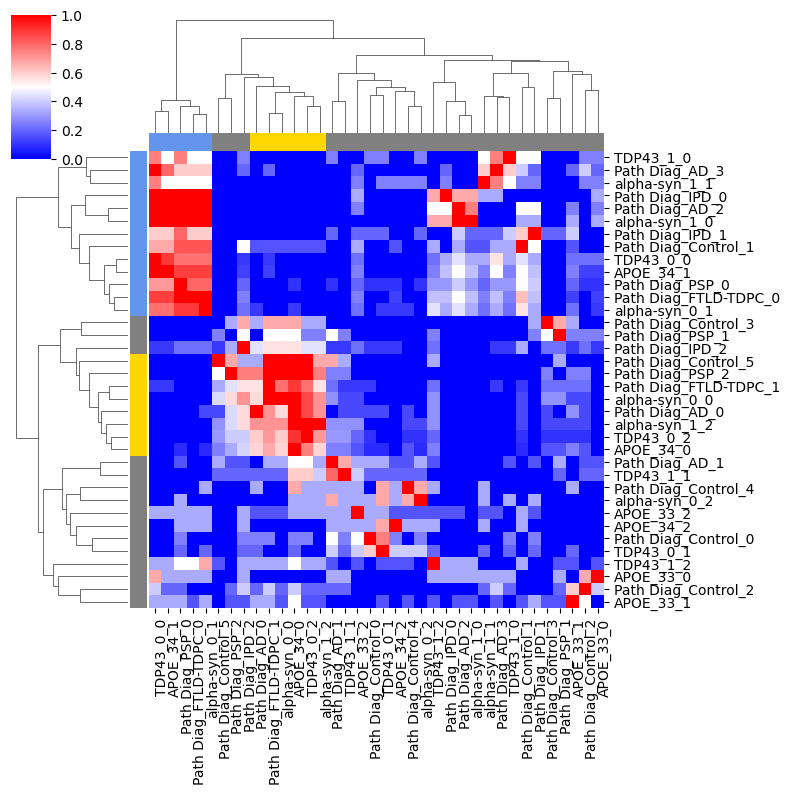

In [295]:
comtrxHM = sns.clustermap(clusterComtrx, cmap='bwr', vmin=0, vmax=1, row_cluster=True, col_cluster=True, xticklabels=clusterComtrxNames, yticklabels=clusterComtrxNames,figsize=(8,8),row_colors=row_colors,col_colors=col_colors)

# Rotate x-tick labels for better visibility
plt.setp(comtrxHM.ax_heatmap.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
plt.setp(comtrxHM.ax_heatmap.get_yticklabels(), rotation=0, ha="left", rotation_mode="anchor")
plt.savefig(os.path.join(plotIGsavepath_thresh,'plots','overlapSPcluster.pdf'))

plt.show()

In [155]:
#two main neighborhood patterns
neigh1=np.unique(np.concatenate((rescluster[0],rescluster_row[0])))
neigh2=np.unique(np.concatenate((rescluster[1],rescluster_row[1])))

neigh1_cluster=[]
for c in neigh1:
    neigh1_cluster.extend(clusterNeigh[c[:-2]][int(c[-1])])
neigh1_cluster=np.unique(neigh1_cluster)

neigh2_cluster=[]
for c in neigh2:
    neigh2_cluster.extend(clusterNeigh[c[:-2]][int(c[-1])])
neigh2_cluster=np.unique(neigh2_cluster)

neighIntersect,neigh1_overlap,neigh2_overlap=np.intersect1d(neigh1_cluster,neigh2_cluster,return_indices=True)
neigh1unique=np.repeat(True,neigh1_cluster.size)
neigh1unique[neigh1_overlap]=False
neigh1_cluster=neigh1_cluster[neigh1unique]

neigh2unique=np.repeat(True,neigh2_cluster.size)
neigh2unique[neigh2_overlap]=False
neigh2_cluster=neigh2_cluster[neigh2unique]

In [156]:
neigh1_cluster

array([ 0.,  3., 13., 14., 18., 36., 39., 62., 66., 74., 82., 94.])

In [157]:
neigh2_cluster

array([ 1.,  4., 11., 17., 21., 28., 32., 53., 97., 99.])

In [158]:
unclustered=[]
for i in cluster2plot_sizeFilter:
    if i not in neigh1_cluster and i not in neigh2_cluster:
        unclustered.append(i)
unclustered

[2.0, 7.0, 19.0, 20.0, 34.0, 84.0, 85.0]

In [159]:
_,neigh1Idx,_=np.intersect1d(cluster2plot_sizeFilter,neigh1_cluster,return_indices=True)
_,neigh2Idx,_=np.intersect1d(cluster2plot_sizeFilter,neigh2_cluster,return_indices=True)
_,unclusteredIdx,_=np.intersect1d(cluster2plot_sizeFilter,unclustered,return_indices=True)
row_order_allIdx=np.concatenate((neigh1Idx,np.concatenate((neigh2Idx,unclusteredIdx))))
row_order_all=cluster2plot_sizeFilter[row_order_allIdx]
row_colors=np.repeat(bgcolor,row_order_all.size).astype('U20')
row_colors[:neigh1_cluster.size]=cluster_colors[0]
row_colors[neigh1_cluster.size:(neigh1_cluster.size+neigh2_cluster.size)]=cluster_colors[1]

In [160]:
row_order_all

array([ 0.,  3., 13., 14., 18., 36., 39., 62., 66., 74., 82., 94.,  1.,
        4., 11., 17., 21., 28., 32., 53., 97., 99.,  2.,  7., 19., 20.,
       34., 84., 85.])

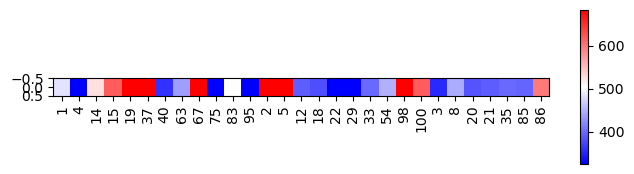

In [207]:
fig, ax = plt.subplots(figsize=(8,2))
plt.imshow(markersum_gfap[1:][row_order_allIdx].reshape(1,-1),cmap='bwr',vmax=np.mean(markersum_gfap)+np.std(markersum_gfap),vmin=np.mean(markersum_gfap)-np.std(markersum_gfap))
ax.set_xticks(np.arange(row_order_allIdx.size))
ax.set_xticklabels(cluster2plot_sizeFilter.astype(int)[row_order_allIdx]+1,rotation=90)
plt.colorbar()
plt.show()

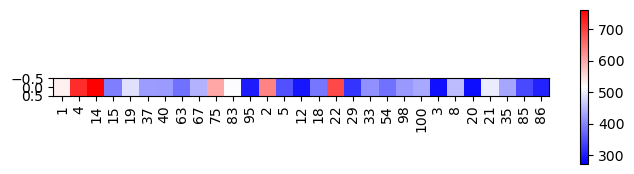

In [208]:
fig, ax = plt.subplots(figsize=(8,2))
plt.imshow(markersum_map2[1:][row_order_allIdx].reshape(1,-1),cmap='bwr',vmax=np.mean(markersum_map2)+np.std(markersum_map2),vmin=np.mean(markersum_map2)-np.std(markersum_map2))
ax.set_xticks(np.arange(row_order_allIdx.size))
ax.set_xticklabels(cluster2plot_sizeFilter.astype(int)[row_order_allIdx]+1,rotation=90)
plt.colorbar()
plt.show()